### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

<h1 id="punto-1">Punto 1</h1>

## Punto 1.1 <a id="punto-1-1"></a>

In [2]:
df_raw_dev_path = r"../data/raw/casas_dev.csv"

df_raw_dev = pd.read_csv(df_raw_dev_path) 

df_raw_dev.sample(5, random_state=12)


,area,area_units,is_house,has_pool,age,price,lat,lon,rooms
431,52.0,m2,1,1,6.0,378.0,-34.603396,-58.381627,2.0
754,646.0,sqft,0,0,2.0,480.0,40.698759,-73.992037,2.0
598,893.0,sqft,0,0,NaN,638.0,40.705754,-74.050902,2.0
368,1055.0,sqft,0,0,14.0,704.0,40.715457,-74.033216,3.0
784,119.0,m2,1,1,NaN,226.0,-34.650660,-58.376238,4.0


In [3]:

df_raw_dev.describe(include='all')


,area,area_units,is_house,has_pool,age,price,lat,lon,rooms
count,900.000000,900,900.000000,900.000000,770.000000,900.000000,900.000000,900.000000,828.000000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,m2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,463,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,533.598889,NaN,0.418889,0.144444,10.212987,466.197778,1.966225,-65.967203,2.737923
std,502.318230,NaN,0.493651,0.351735,4.773010,347.122903,37.661269,7.813671,0.948574
min,40.000000,NaN,0.000000,0.000000,1.000000,65.000000,-34.686302,-74.058238,1.000000
25%,93.000000,NaN,0.000000,0.000000,6.250000,178.750000,-34.605803,-74.005566,2.000000
50%,164.500000,NaN,0.000000,0.000000,11.000000,323.500000,-34.529704,-58.459293,3.000000
75%,980.000000,NaN,1.000000,0.000000,14.000000,712.500000,40.709819,-58.379873,3.000000


Algo que es particular resaltar es que la feature ```area_units``` no tiene sentido que se mantenga. Es posible realizar una conversión a metros cuadrados, eliminar está feature y agregar ```area``` en metros cuadrados.

Se convierte la feature ```sqft``` a ```m2``` y se elimina la columna ```area_units```

In [4]:
from utils.data import preprocess_data

df_preprocessed_path = r"../data/processed/casas_dev.csv"

# df_preprocessed_dev = preprocess_data(df_raw_dev, df_preprocessed_path)

df_preprocessed_dev = pd.read_csv(df_preprocessed_path)

df_preprocessed_dev.describe(include='all')

,area,is_house,has_pool,age,price,lat,lon,rooms
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,94.794747,0.418889,0.144444,10.212987,466.197778,1.966225,-65.967203,2.737923
std,30.220560,0.493651,0.351735,4.414441,347.122903,37.661269,7.813671,0.909797
min,40.000000,0.000000,0.000000,1.000000,65.000000,-34.686302,-74.058238,1.000000
25%,74.000000,0.000000,0.000000,7.000000,178.750000,-34.605803,-74.005566,2.000000
50%,92.995903,0.000000,0.000000,10.212987,323.500000,-34.529704,-58.459293,2.737923
75%,111.264314,1.000000,0.000000,13.000000,712.500000,40.709819,-58.379873,3.000000
max,237.000000,1.000000,1.000000,20.000000,1992.000000,40.764550,-58.295919,5.000000


In [5]:
df_raw_test_path = r"../data/raw/casas_test.csv"

df_test_0_raw = pd.read_csv(df_raw_test_path)

df_preprocessed_test_path = r"../data/processed/casas_test.csv"

# df_preprocessed_test = preprocess_data(df_test_0_raw, df_preprocessed_test_path)

df_preprocessed_test = pd.read_csv(df_preprocessed_test_path)



Hacemos un análisis de las features que contienen NaNs.

In [6]:
from utils.data import get_nan_features

nan_features = get_nan_features(df_preprocessed_dev) 

print("Features con valores nulos y su cantidad de valores nulos: ", list(nan_features.items()))


Features con valores nulos y su cantidad de valores nulos:  []


Se observa que las features con ```NaNs``` son ```age``` y ```room```.

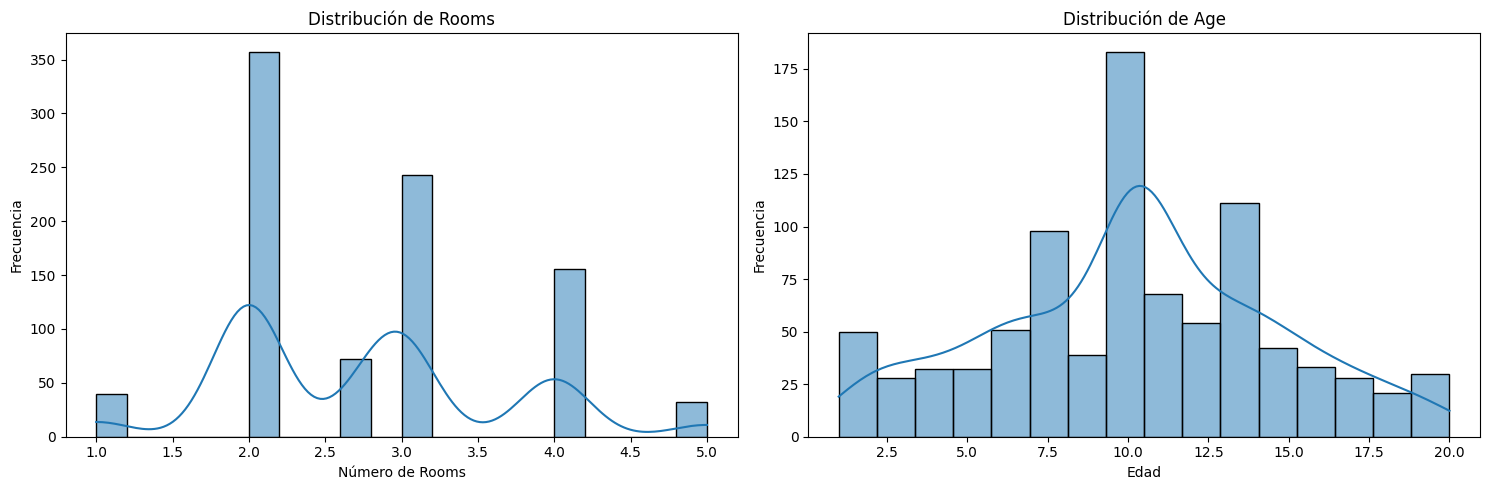

In [7]:

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df_preprocessed_dev['rooms'], kde=True, ax=axes[0])
axes[0].set_title('Distribución de Rooms')
axes[0].set_xlabel('Número de Rooms')
axes[0].set_ylabel('Frecuencia')

sns.histplot(df_preprocessed_dev['age'], kde=True, ax=axes[1])
axes[1].set_title('Distribución de Age')
axes[1].set_xlabel('Edad')
axes[1].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [8]:
# ver cantidad de filas que se pierden
print("Cantidad de filas que se pierden:", df_preprocessed_dev.isna().sum().sum())


Cantidad de filas que se pierden: 0


Notar que la media de ```roooms``` es ```2.737``` y que la media de ```age``` es ```10.212```. Es posible reemplazar en las muestras (filas) que tienen ```NaNs``` con la media. Al reemplazar los valores perdidos (NaNs) con la media, se mantiene la escala original de la variable y se evitan valores atípicos fuera de rango, lo que ayuda a preservar en cierta medida la distribución.

Esto es un proceso válido ya que al reemplazar los ```NaNs``` con la media, a primera vista, la variable conserva su escala original (no se generan valores fuera de rango ni se produce un sesgo), lo que ayuda a mantener la consistencia de la información que aporta esa variable. 

Sin embargo, si en el conjunto de datos existen varios grupos con medias distintas, imputar los valores faltantes con una única media global genera una sobreestimación en los grupos cuya media es menor y una subestimación en aquellos con una media mayor. Esto distorsiona la distribución real de cada subgrupo, lo que puede conducir a conclusiones equivocadas al mezclar la información de todos los grupos en un solo valor (ver inciso 4).

Además, al ignorar las diferencias entre subgrupos, se pierden matices importantes de la variabilidad interna de los datos, lo que introduce un sesgo sistemático. 

También se podrían eliminar las filas que tienen ```NaNs```, pero esto haría que se pierdan 202 filas, opción que se optará por no realizar ya que se pierde información en gran cantidad.

Por último, otra solución sería utilizar un modelo NO LINEAL para predecir estas features, opción que también no se llevará a cabo debido a que excede el objetivo de este TP.




In [9]:

features_to_impute = ['rooms', 'age']


for feature in features_to_impute:

    mean_value = df_preprocessed_dev[feature].mean()
    
    df_preprocessed_dev[feature] = df_preprocessed_dev[feature].fillna(mean_value)
    
    print(f'Imputando en {feature} con la media: {mean_value}')
    


Imputando en rooms con la media: 2.7379227053140096
Imputando en age con la media: 10.212987012987014


In [10]:
df_preprocessed_dev.to_csv(df_preprocessed_path, index=False)

## Punto 1.2 <a id="punto-1-2"></a>


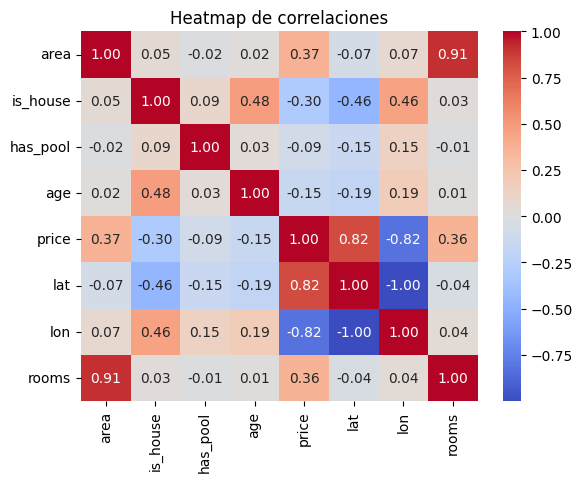

,area,is_house,has_pool,age,price,lat,lon,rooms
area,1.000000,0.047767,-0.020012,0.020607,0.371862,-0.071974,0.071787,0.907964
is_house,0.047767,1.000000,0.093175,0.482947,-0.298412,-0.459865,0.459664,0.029574
has_pool,-0.020012,0.093175,1.000000,0.033317,-0.088624,-0.146234,0.146399,-0.007955
age,0.020607,0.482947,0.033317,1.000000,-0.149007,-0.194795,0.194773,0.013094
price,0.371862,-0.298412,-0.088624,-0.149007,1.000000,0.822490,-0.822537,0.359635
lat,-0.071974,-0.459865,-0.146234,-0.194795,0.822490,1.000000,-0.999992,-0.040040
lon,0.071787,0.459664,0.146399,0.194773,-0.822537,-0.999992,1.000000,0.039892
rooms,0.907964,0.029574,-0.007955,0.013094,0.359635,-0.040040,0.039892,1.000000


In [11]:

corr = df_preprocessed_dev.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de correlaciones')
plt.show()

corr

Notar que la variable area presenta una correlación muy alta de 0.91 con rooms lo que es totalmente coherente, ya que a medida que aumenta la cantidad de habitaciones, la superficie total de la propiedad tiende a crecer. Además, la latitud (lat) muestra una fuerte correlación positiva de 0.82 con price, lo que sugiere que las propiedades ubicadas en zonas con mayor latitud tienden a tener precios más altos; en contraposición, la longitud (lon) tiene una correlación negativa de -0.82 con price, lo que indica que en las áreas donde la longitud es mayor, los precios son más bajos. Esto podría interpretarse como que existen zonas geográficas diferenciadas, donde la posición en el mapa influye significativamente en el valor de la propiedad. 

Por otro lado, se observa una correlación moderada de 0.48 entre is_house y age, lo que sugiere que las casas (frente a otros tipos de propiedades) tienden a ser más antiguas. Asimismo, is_house se relaciona moderadamente con las coordenadas: presenta una correlación de -0.46 con lat y de 0.46 con lon, lo que puede indicar que las casas se concentran en áreas geográficas específicas distintas a aquellas de otros inmuebles. 

Finalmente, resulta destacable la 'perfecta' correlación negativa de -1.0 entre lat y lon, lo que implica que, dentro del rango de datos, a medida que aumenta la latitud, la longitud disminuye de forma casi lineal, reflejando probablemente una distribución geográfica particular de las propiedades. Estos patrones ayudan a entender que la ubicación y el tipo de inmueble son determinantes importantes en la configuración del precio y otras características de las viviendas en el dataset. Incluso se podría clasificar las casas por zonas (clusters) en base a la latitud y longitud <details>
<summary>Spoiler alert</summary>
lo hago en el inciso 4)
</details>

En el siguiente gráfico se observan en mayor detalle las relaciones entre las variables.

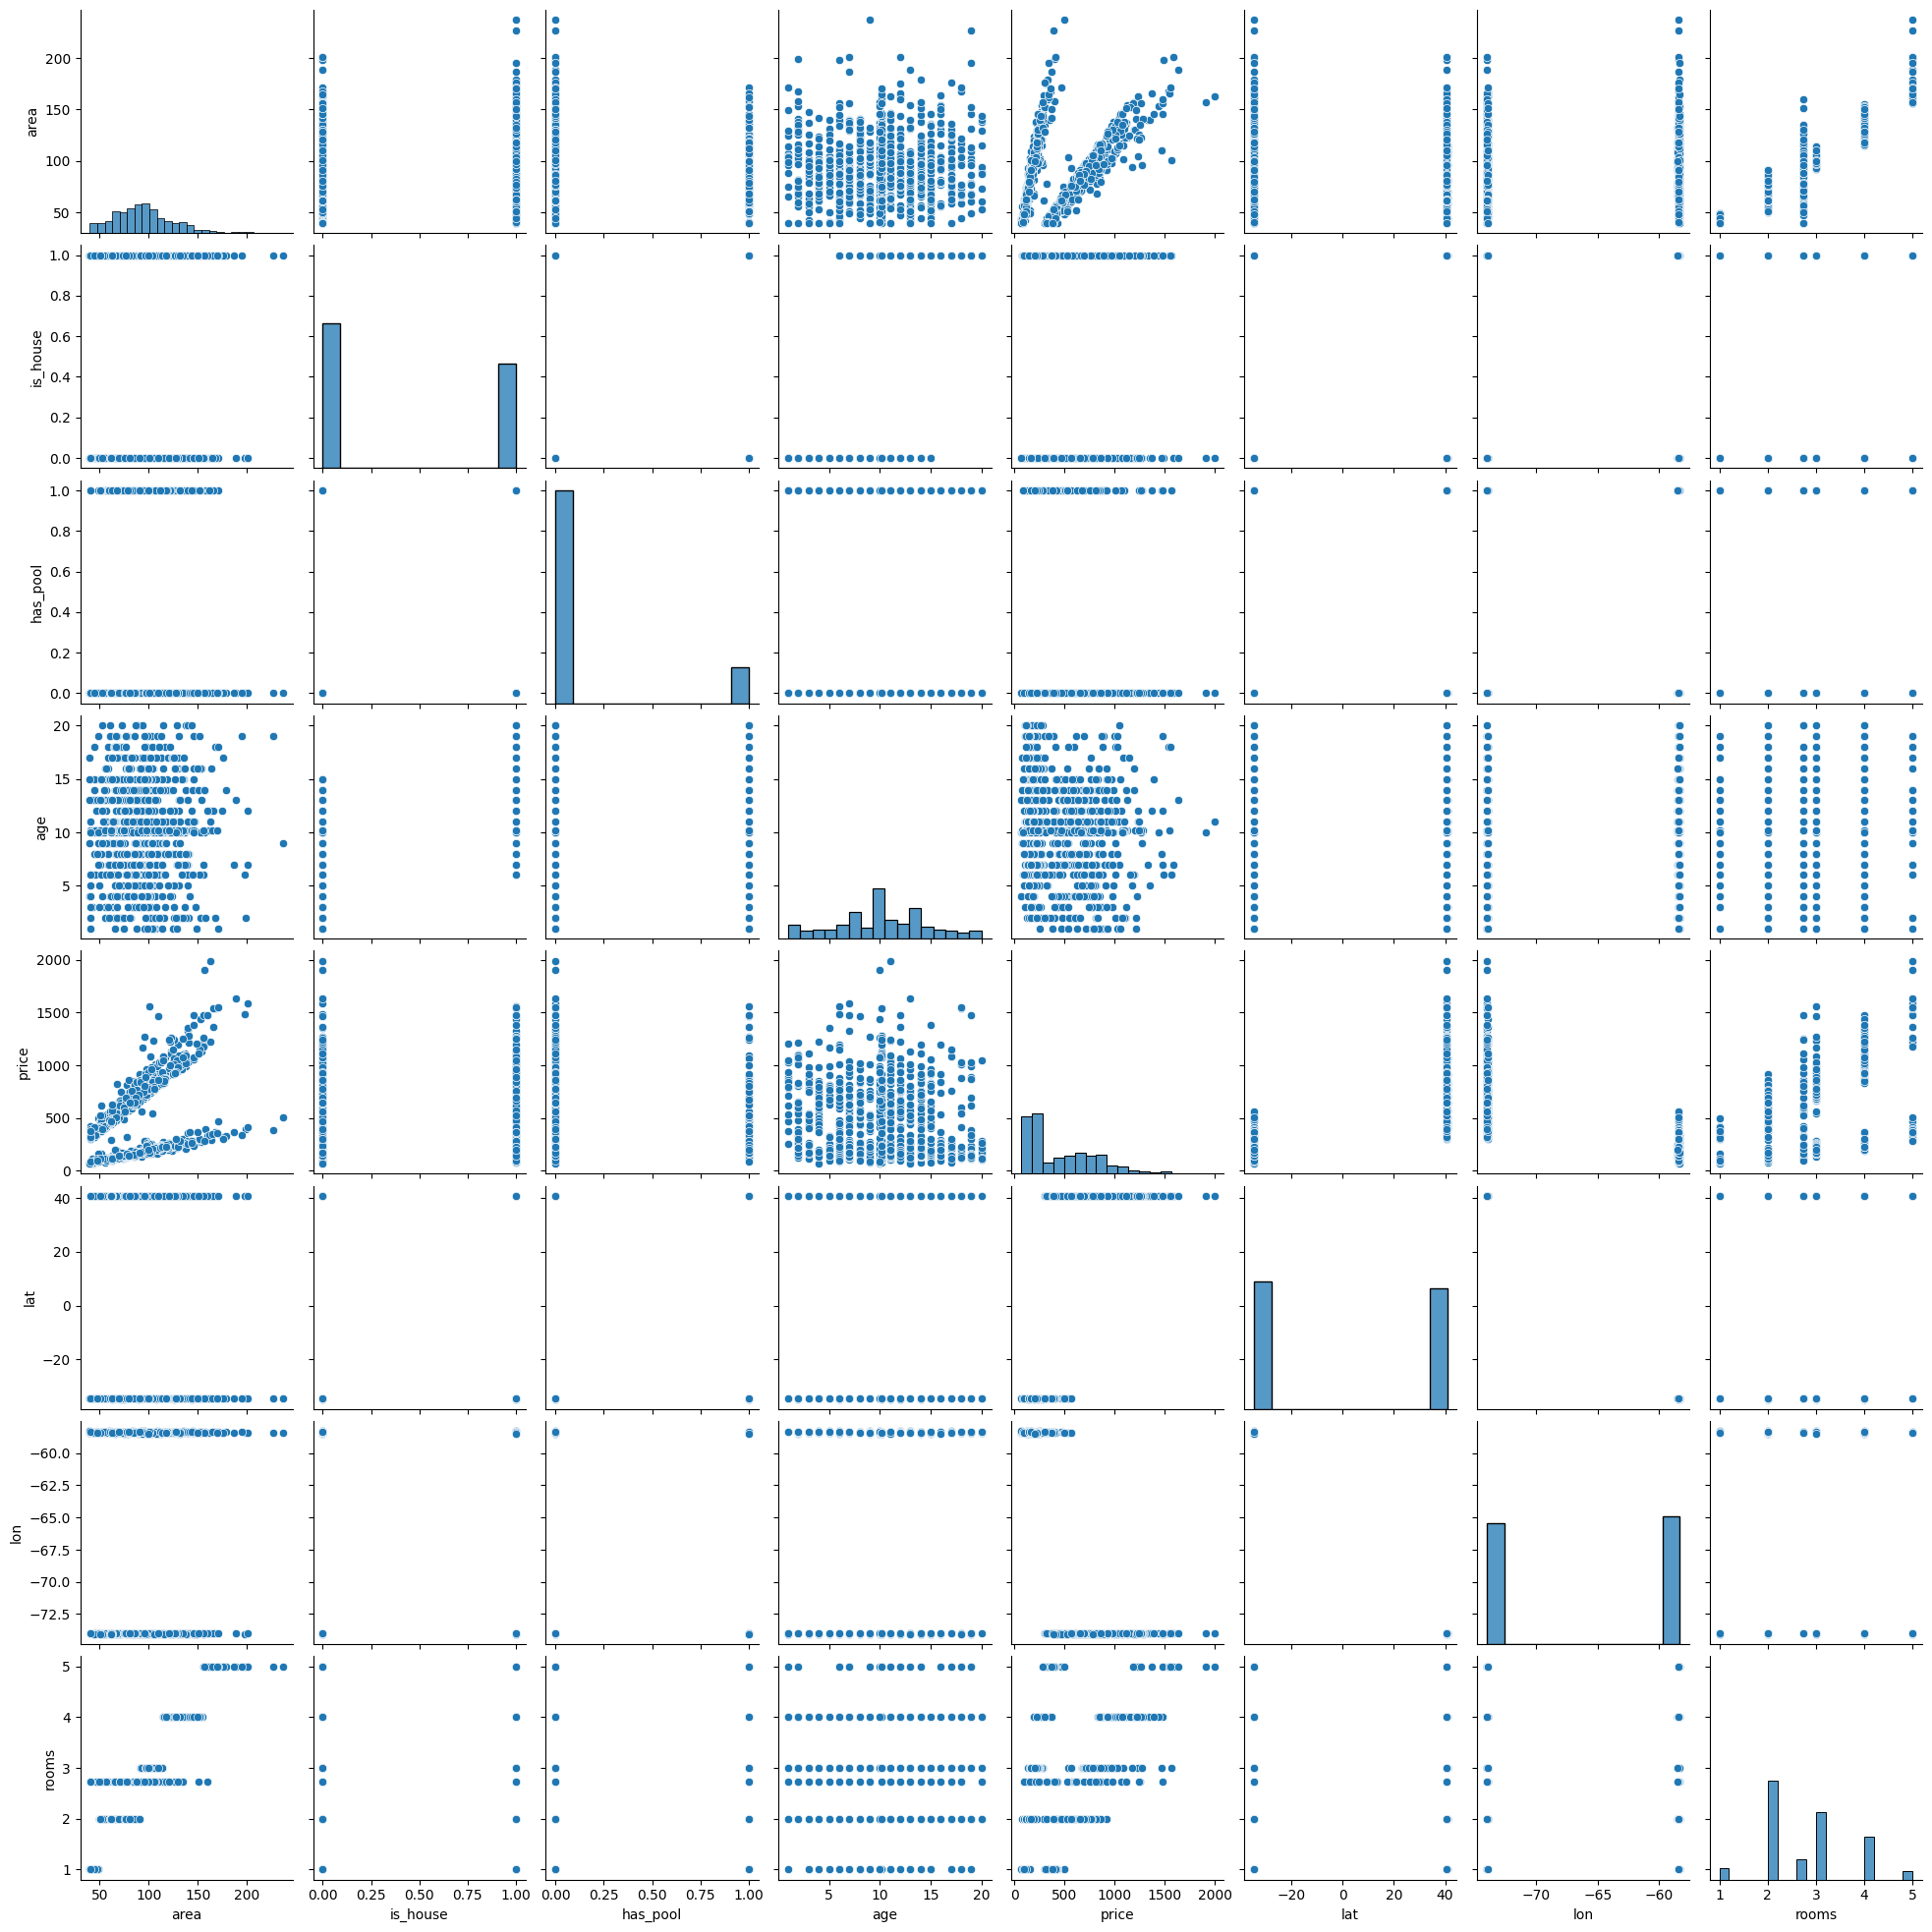

In [12]:
sns.pairplot(df_preprocessed_dev)
plt.show()

Se observa en los gráficos de latitud y longitud como estan estrictamente correlacionados con una pendiente negativa. Parece haber 2 clusters en el mismo, caracteristica que se 'explota' en el inciso 4. 

Por otro lado, en el grafico de area vs price se nota una correlacion positiva, lo que indicaría que a mayor area mayor es el precio, algo que es relativamente logico. Similarmente se nota este patron en el gráfico de rooms vs price y rooms vs area.

También se observa una correlacion positiva (como ya se ha mencionado) entre latitud vs price, dando un indicador que ciertas zonas tienden a incrementar el valor de los inmuebles, mientras que la longitud vs price tiene una correlacion negativa, indicando que ciertas zonas tienden a disminuir el valor de los inmuebles.

Por ultimo, notar como, si el inmueble es una casa, tiende a tener mayor edad que aquellos que no lo son. 



## Punto 1.3 <a id="punto-1-3"></a>


In [13]:
from utils.data import split_test_train


X = df_preprocessed_dev.drop('price', axis=1)
y = df_preprocessed_dev['price']


X_train, X_test, y_train, y_test = split_test_train(X, y, test_size=0.2, random_state=12,normalize=True)


# Punto 2

### Punto 2.1

In [14]:
from models.regression.linear_regressor import LinearRegressor

### Punto 2.2

In [15]:
from utils.data import mse_score, r2_score

### Punto 2.3

In [16]:
from utils.model import train_and_evaluate_model

#### Probamos que el modelo con 1 feature funciona bien


Pseudo Inversa

In [17]:

results_linear_psinv_area = train_and_evaluate_model( 
    data_path=df_preprocessed_path,
    target_column="price",
    test_size=0.20,
    random_state=12,
    feature_columns = ["area"],
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=[mse_score, r2_score]
)

model_linear_psinv_area = results_linear_psinv_area["model"]

Method: pseudo_inverse
Intercept: 75.5102

Coefficients:
------------------------------
area            | +4.0167


Gradiente Descendente


In [18]:

results_gd_linear_area = train_and_evaluate_model( 
    data_path=df_preprocessed_path,
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=LinearRegressor,
    feature_columns = ["area"],
    normalize_features=True,
    fit_params={'method': 'gradient_descent',
                "epochs": 1000,
                "learning_rate":0.01
                },
    metrics=[mse_score, r2_score],
    verbose=True
)

model_gd_linear_area = results_gd_linear_area["model"]



Method: gradient_descent
Intercept: 455.7119

Coefficients:
------------------------------
area            | +123.4822
Convergence: Yes
Iterations: 569/1000


### Todas las features (menos price)

#### Pseudo Inversa

In [19]:

results_linear_psinv_all = train_and_evaluate_model( 
    data_path=df_preprocessed_path,
    target_column="price",
    test_size=0.20,
    random_state=12,
    transform_target=None,
    model_class=LinearRegressor,
    normalize_features=False,
    fit_params={'method': "pseudo_inverse",
                "loss": "mse"},
    metrics=[mse_score, r2_score]
)

model_linear_psinv_all = results_linear_psinv_all["model"]


Method: pseudo_inverse
Intercept: 3677.5350

Coefficients:
------------------------------
area            | +4.9952
is_house        | +75.3474
has_pool        | +43.4141
age             | -3.4354
lat             | +19.9893
lon             | +56.3301
rooms           | -3.9214


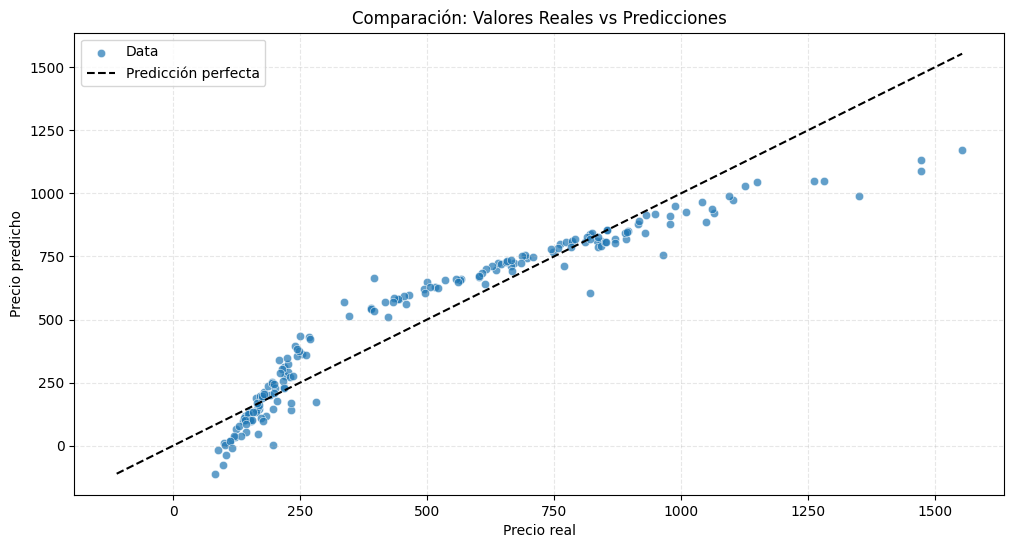

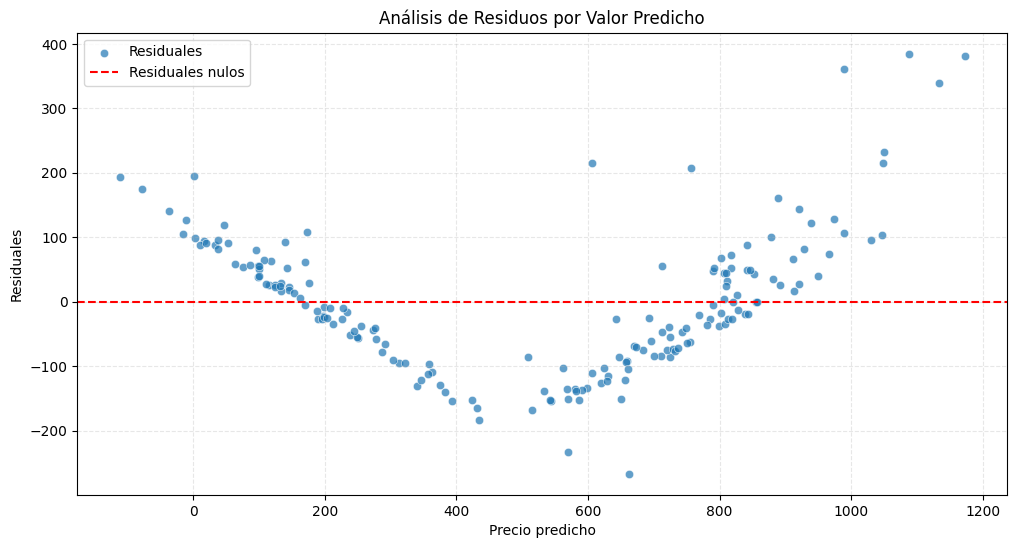

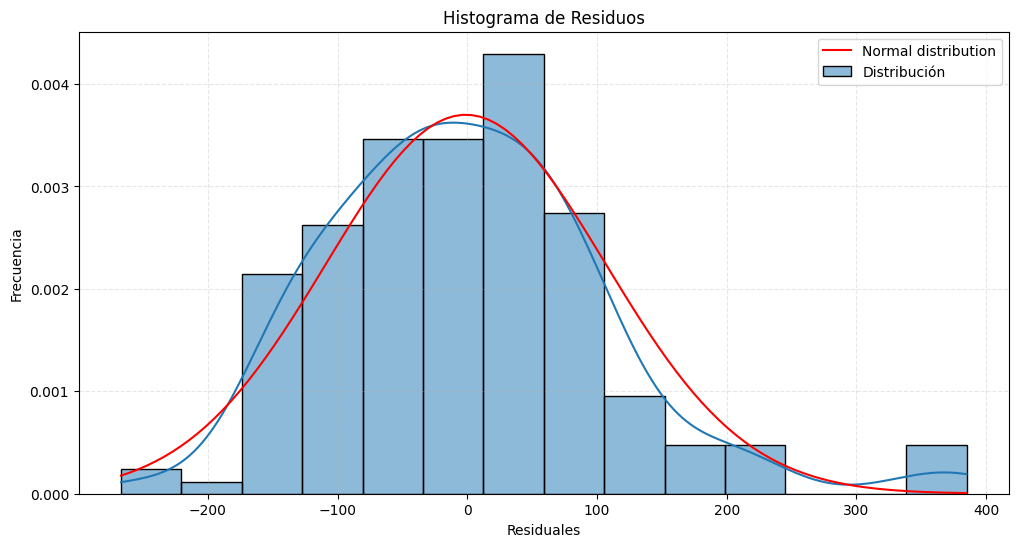

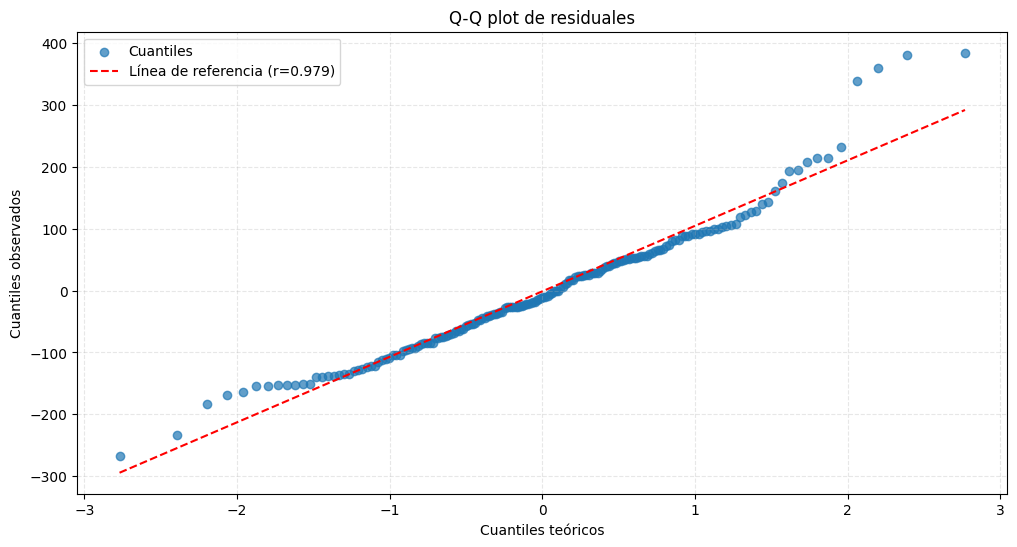

In [20]:
from utils.visuals import visualize_regression_results

custom_titles = {
    "scatter": "Comparación: Valores Reales vs Predicciones",
    "residuals": "Análisis de Residuos por Valor Predicho",
    "distribution": "Histograma de Residuos"
}


figures_linear_psinv_all = visualize_regression_results(
    results_linear_psinv_all['y_test'],
    results_linear_psinv_all['y_pred_test'],
    transform_func=None,
    fig_size=(12, 6),
    titles=custom_titles,
    show_figures=True
)



A partir de los gráficos es posible derivar diferentes conclusiones. En el diagrama de precios predichos versus residuos, la varianza de los errores no es constante a lo largo de todo el rango de valores, presentándose una curvatura empinada que sugiere que el modelo no está capturando de forma adecuada la relación subyacente (lo que podría indicar la presencia de heterocedasticidad o una especificación funcional inadecuada). El Q-Q plot, asumiendo una distribución normal, revela que los residuos en general se aproximan a la normalidad, aunque se observan leves desvíos en las colas, lo que podría atribuirse a la influencia de outliers. Esto, junto con el histograma de residuos, confirma que los errores de predicción varían a lo largo del rango de valores, en contraste con lo que se esperaría de un buen ajuste, en el cual los residuos deberían concentrarse en un entorno cercano al cero.

Dado que la mayoría de los residuos se comportan de manera normal, podemos inferir que el modelo no está sobreajustado; en situaciones de overfitting, los errores serían extremadamente pequeños y concentrados en torno a cero. Sin embargo, la variabilidad en la dispersión de los residuos y la curvatura observada sugieren que el modelo podría estar omitiendo relaciones no lineales o interacciones importantes entre las variables. Por ello, se prodría revisar la forma funcional del modelo, incorporando términos polinómicos o interacciones según corresponda, para capturar mejor la complejidad de la relación entre las variables predictoras y la respuesta.

Por otro lado, técnicas de regularización como Ridge o Lasso pueden ayudar a mitigar problemas de multicolinealidad y reducir la varianza de las estimaciones de los coeficientes, lo cual resulta útil en escenarios de sobreajuste. Sin embargo, es importante recalcar que estas técnicas no abordan de manera directa el problema de la heterocedasticidad; para ello, se podría considerar el uso de métodos robustos o transformaciones de las variables que estabilicen la varianza de los errores.


#### Gradient Descent

In [21]:

results_gd_linear_all = train_and_evaluate_model(
    data_path=df_preprocessed_path,
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=True,
    fit_params={'method': 'gradient_descent',
                "epochs": 1000,
                "learning_rate":0.01
                },
    metrics=[mse_score, r2_score]
)

model_gd_linear_all = results_gd_linear_all["model"]


Method: gradient_descent
Intercept: 413.8982

Coefficients:
------------------------------
area            | +139.6746
is_house        | +81.4740
has_pool        | +44.8361
age             | -16.0991
lat             | +156.6366
lon             | -156.4345
rooms           | +10.1953
Convergence: Yes
Iterations: 1000/1000


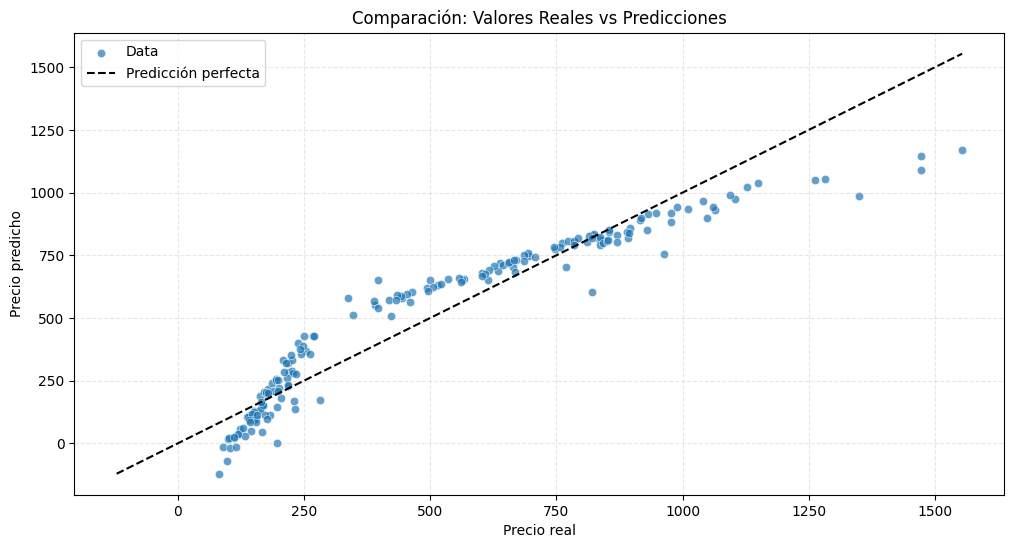

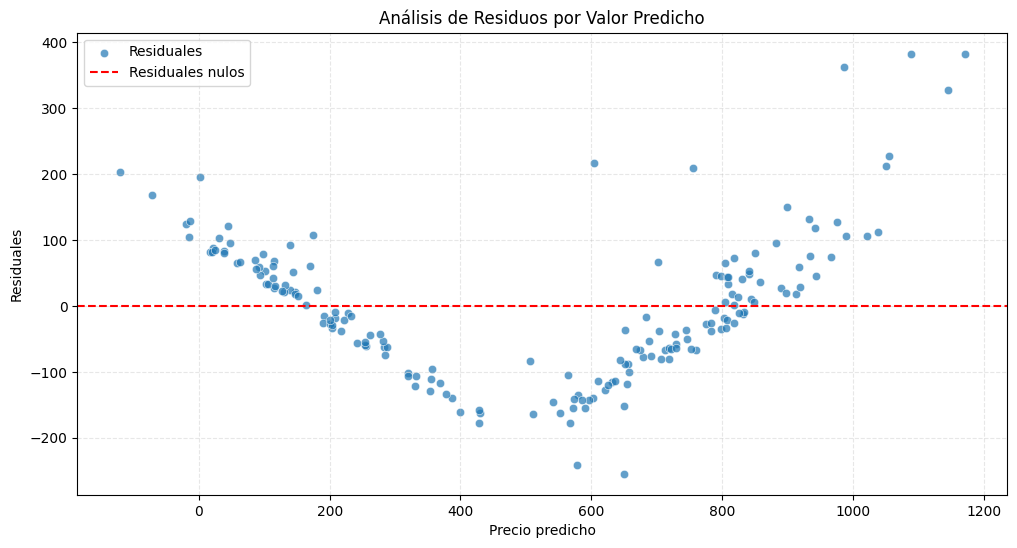

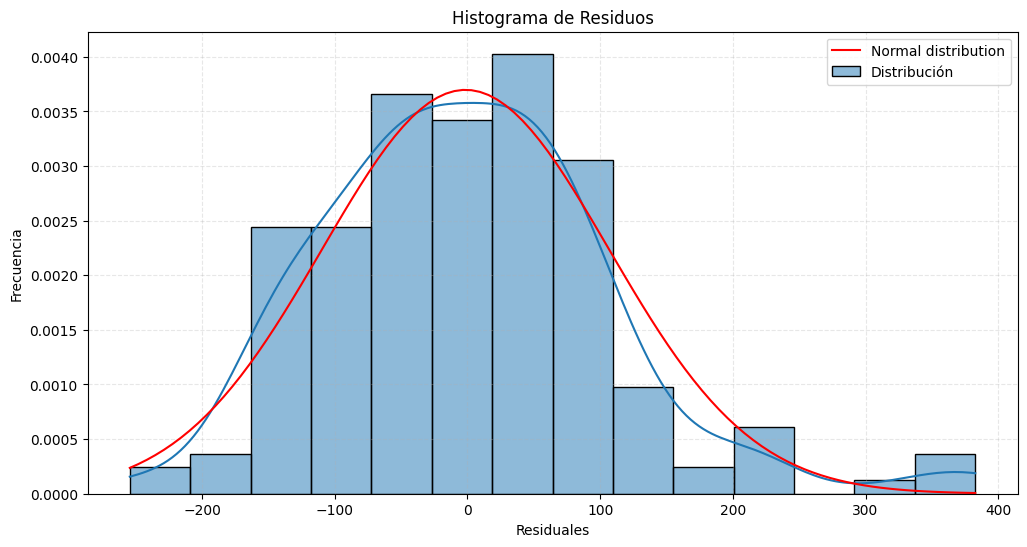

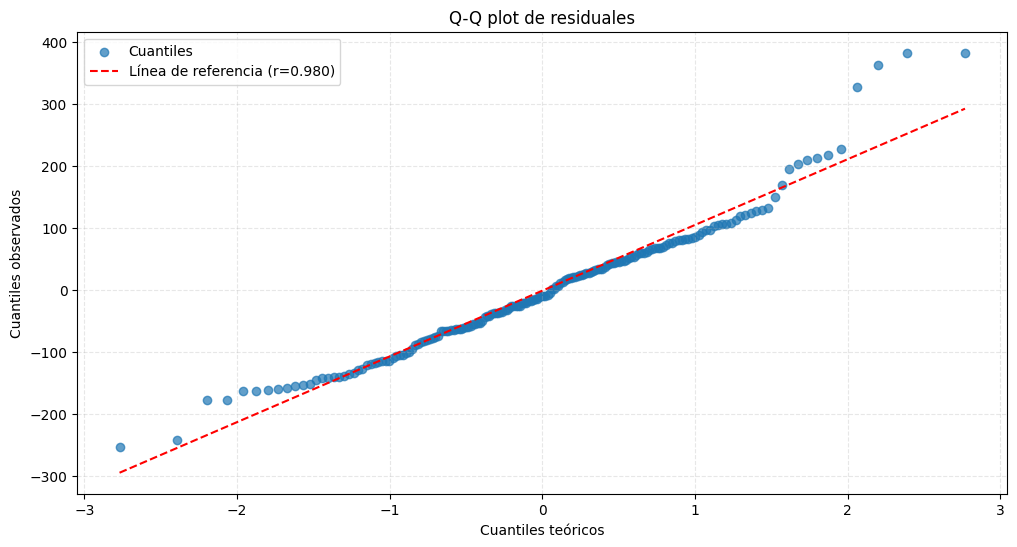

In [22]:

custom_titles = {
    "scatter": "Comparación: Valores Reales vs Predicciones",
    "residuals": "Análisis de Residuos por Valor Predicho",
    "distribution": "Histograma de Residuos"
}

figures = visualize_regression_results(
    results_gd_linear_all['y_test'],
    results_gd_linear_all['y_pred_test'],
    transform_func=None,
    fig_size=(12, 6),
    titles=custom_titles,
    show_figures=True,
    fit_degree=1
)





Mismo análisis de heterocedasticidad y distribución de residuos que el anterior.

# Punto 3

#### Punto 3.1

In [23]:

df_area_all_type_houses = pd.read_csv(df_preprocessed_path)

results_area_all_type_houses = train_and_evaluate_model( 
    df = df_area_all_type_houses,
    target_column="price",
    test_size=0.20,
    random_state=12,
    feature_columns = ["area"],
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=[mse_score, r2_score],
    verbose=False
)

model_area_all_type_houses  = results_area_all_type_houses["model"]




#### Punto 3.2

In [24]:
amanda_path = r"../vivienda_Amanda.csv"

df_amanda = pd.read_csv(r"../vivienda_Amanda.csv")

amanda_processed_path = r"../data/processed/vivienda_Amanda.csv"
df_amanda = preprocess_data(df_amanda, amanda_processed_path)


In [25]:

results_amanda = train_and_evaluate_model( 
    data_path=df_preprocessed_path,
    target_column="price",
    test_size=0.20,
    random_state=12,
    transform_target=None,
    model_class=LinearRegressor,
    normalize_features=False,
    fit_params={'method': "pseudo_inverse",
                "loss": "mse"},
    metrics=[mse_score, r2_score]
)

model_amanda = results_amanda["model"]


Method: pseudo_inverse
Intercept: 3677.5350

Coefficients:
------------------------------
area            | +4.9952
is_house        | +75.3474
has_pool        | +43.4141
age             | -3.4354
lat             | +19.9893
lon             | +56.3301
rooms           | -3.9214


In [26]:
y_pred = model_amanda.predict(df_amanda)

print(f"Valor estimado de la vivienda de Amanda: {y_pred[0]:.2f}")

Valor estimado de la vivienda de Amanda: 791.19


### Punto 3.3

In [27]:

df_area = pd.read_csv(df_preprocessed_path)
df_area = df_area[df_area["is_house"] == 1]

results_area = train_and_evaluate_model( 
    df = df_area,
    target_column="price",
    test_size=0.20,
    random_state=12,
    feature_columns = ["area"],
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=[mse_score, r2_score],
    verbose=False
)

model_area = results_area["model"]


area_cof = model_area.get_coef_dict()["area"]

print(f"El valor promedio por metro cuadrado de una casa es: {area_cof:.2f}")

El valor promedio por metro cuadrado de una casa es: 3.64


El coeficiente de 3.64 obtenido en el modelo de regresión lineal representa el valor promedio por metro cuadrado de una casa porque refleja directamente cuánto aumenta el precio de una vivienda por cada metro cuadrado adicional.
En una regresión lineal simple como esta, donde solo se utiliza el área como variable predictora, la ecuación del modelo es:

```Precio = Intercepción + Coeficiente_área × Área```

Este coeficiente de 3.64 cuantifica exactamente cuánto cambia el precio cuando el área aumenta en una unidad (un metro cuadrado). En otras palabras, cada metro cuadrado adicional contribuye, en promedio, 3.64 unidades monetarias al precio total de la propiedad.

### Punto 3.4

In [28]:

df_pool_house = pd.read_csv(df_preprocessed_path)
df_pool_house = df_pool_house[df_pool_house["is_house"] == 1]

results_pool_house = train_and_evaluate_model( 
    df = df_pool_house,
    target_column="price",
    test_size=0.20,
    random_state=12,
    feature_columns = ["has_pool","area","age","rooms","lat","lon"],
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=[mse_score, r2_score],
    verbose=False
)

model_pool_house = results_pool_house["model"]


house_pool_cof = model_pool_house.get_coef_dict()["has_pool"]



In [29]:


df_pool_dept = pd.read_csv(df_preprocessed_path)
df_pool_dept = df_pool_dept[df_pool_dept["is_house"] == 0]

results_pool_dept = train_and_evaluate_model( 
    df = df_pool_dept,
    target_column="price",
    test_size=0.20,
    random_state=12,
    feature_columns = ["has_pool","area","age","rooms","lat","lon"],
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=[mse_score, r2_score],
    verbose=False
)

model_pool_dept = results_pool_dept["model"]


dept_pool_cof = model_pool_dept.get_coef_dict()["has_pool"]




In [30]:

df_pool = pd.read_csv(df_preprocessed_path)

results_pool_combined = train_and_evaluate_model( 
    df = df_pool,
    target_column="price",
    test_size=0.20,
    random_state=12,
    feature_columns = ["has_pool","area","age","rooms","lat","lon"],
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=[mse_score, r2_score],
    verbose=False
)

model_pool_combined = results_pool_combined["model"]


dept_pool_cof = model_pool_combined.get_coef_dict()["has_pool"]



In [31]:
from utils.data import compare_feature_impact

model_results = {
    "Departamentos": results_pool_dept,
    "Casas": results_pool_house,
    "Casas y Departamentos (Combinado)": results_pool_combined
}

property_data = {
    "Departamentos": df_pool_dept,
    "Casas": df_pool_house,
    "Casas y Departamentos (Combinado)": df_pool
}

impacts = compare_feature_impact(
    model_results_dict=model_results,
    property_dfs=property_data,
    feature_name='has_pool'
)

for model_name, impact_data in impacts.items():
    display_name = impact_data["display_name"]
    feature_impact = impact_data["absolute_impact"]
    avg_property_price = impact_data["average_price"]
    percentage_impact = impact_data["percentage_impact"]
    
    print(f"\nImpacto de agregar {display_name} para {model_name}:")
    print(f"- Valor absoluto agregado: ${feature_impact:.2f}")
    print(f"- Precio promedio de {model_name}: ${avg_property_price:.2f}")
    print(f"- Incremento porcentual sobre el promedio: {percentage_impact:.2f}%")


Impacto de agregar Pool para Departamentos:
- Valor absoluto agregado: $52.68
- Precio promedio de Departamentos: $554.10
- Incremento porcentual sobre el promedio: 9.51%

Impacto de agregar Pool para Casas:
- Valor absoluto agregado: $13.82
- Precio promedio de Casas: $344.26
- Incremento porcentual sobre el promedio: 4.01%

Impacto de agregar Pool para Casas y Departamentos (Combinado):
- Valor absoluto agregado: $45.13
- Precio promedio de Casas y Departamentos (Combinado): $466.20
- Incremento porcentual sobre el promedio: 9.68%


La construcción de una pileta, según el análisis realizado, podría incrementar el valor de la propiedad en distintos porcentajes: en departamentos se observó un aumento promedio de USD 52.68 (9.51% sobre un precio promedio de 554.10), en casas un incremento de 13.82 (4.01% sobre 344.26) y, considerando un análisis combinado, un aumento de 45.13 (9.68% sobre 466.20); estos resultados se obtuvieron al “activar” la variable de pileta en el modelo y medir la diferencia en la predicción del precio, lo que aísla el impacto de esta amenidad, y es posible que la mayor apreciación en departamentos se deba a que, en contextos donde la oferta de amenities es más limitada o exclusiva, la incorporación de una pileta se perciba como un valor añadido significativamente mayor, mientras que en casas, donde las opciones de espacio y personalización son más amplias, el impacto relativo resulta menor.

# Punto 4

Después de tanto tiempo, finalmente, el aclamado punto 4. 

#### Observamos si nuestros datos se pueden agrupar por zonas geográficas

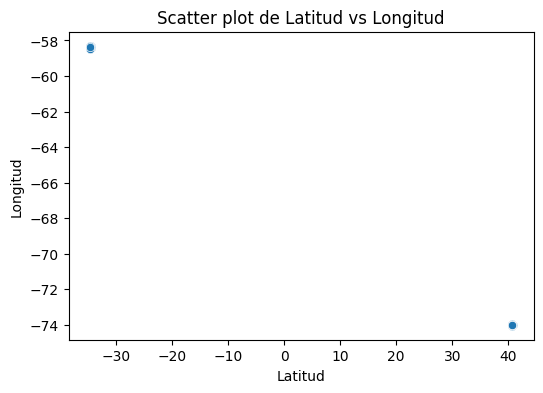

In [32]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_preprocessed_dev, x='lat', y='lon')
plt.title('Scatter plot de Latitud vs Longitud')
plt.xlabel('Latitud')
plt.ylabel('Longitud')
plt.show()

Se observa una clara agrupación por zonas geográficas.
#### Feature Engineering

In [33]:
df_raw_dev_path = r"../data/raw/casas_dev.csv"

df_raw_dev = pd.read_csv(df_raw_dev_path)

df_raw_dev = preprocess_data(df_raw_dev)

In [34]:
from utils.data import process_dataset
from models.clustering.kmeans import KMeans


kmeans = KMeans(n_clusters=2) 

engineering_ops = [
      
        {
            'name': 'pool_house', 
            'operation': lambda df: df['has_pool'] * df['is_house']
        },
        
        {
            'name': 'house_area', 
            'operation': lambda df: df['area'] * df['is_house']
            
        },

        {
            'name': 'dist_to_cluster_center', 
            'operation': lambda df: 
                np.array([
                    np.linalg.norm(
                        df.loc[i, ['lat', 'lon']].values - 
                        kmeans.cluster_centers_[df.loc[i, 'location_zone'].astype(int)]
                    ) 
                    for i in df.index
                ])
        }

]

df_eng_dev_path = "../data/processed/casas_dev_eng_mean_impute.csv"
processed = process_dataset(
    df=df_raw_dev,
    kmeans_model=kmeans,  
    feature_engineering_ops=engineering_ops,
    features_to_impute=['rooms', 'age'],
    location_columns=['lat', 'lon'],
    impute_by_zone=True,  
    create_zone_interactions=True,
    zone_interaction_features=['area', 'rooms', 'age', 'has_pool', 'is_house', 'house_area', 'pool_house', 'dist_to_cluster_center'],
    save_path=df_eng_dev_path
)

df_processed = processed['df']
location_data = processed['df_pos']
zone_statistics = processed['zone_stats']
feature_statistics = processed['feature_stats']




Al utilizar estas features, se logran crear clusters que permiten agrupar las propiedades por zonas geográficas, y además capturar relaciones entre variables las features que el modelo lineal solo no podría. Al agregas features del estilo _feature-x_ $\times$ ```location_zone```, se obtiene una interacción entre la feature y la zona, permitiendo crear una especie de $''\textbf{ensamble}''$ de modelos lineales, uno por cada zona.

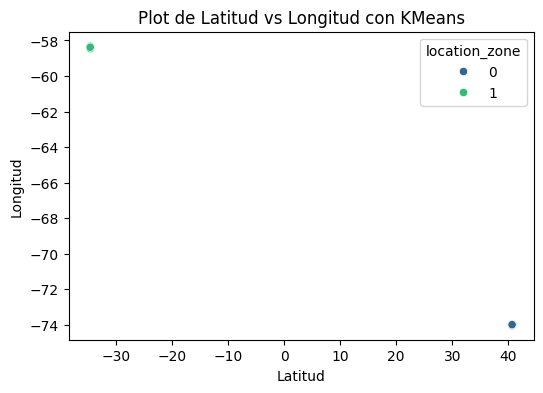

In [35]:

plt.figure(figsize=(6, 4))
sns.scatterplot(data=location_data, x='lat', y='lon', hue='location_zone', palette='viridis')
plt.title('Plot de Latitud vs Longitud con KMeans')
plt.xlabel('Latitud')
plt.ylabel('Longitud')
plt.show()


## Punto 4.2

In [36]:

df_imputed = pd.read_csv(df_eng_dev_path)

results_engineering = train_and_evaluate_model(
    df=df_imputed, 
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=LinearRegressor,
    transform_target=np.log,
    inv_transform_pred=np.exp,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=[mse_score, r2_score],
    verbose=False
)

model_engineering = results_engineering["model"]


mse_first_model = results_linear_psinv_all["mse"] 
r2_first_model = results_linear_psinv_all["r2"]

mse_engineering = results_engineering["mse"]
r2_engineering = results_engineering["r2"]



In [37]:

# calcular cuanto mejor es el modelo con feature engineering porcentualmente comparado al primer modelo lineal 
improvement_mse = ((mse_first_model - mse_engineering) / mse_first_model) * 100
improvement_r2 = ((r2_engineering - r2_first_model) / r2_first_model) * 100


In [38]:

print(f"El modelo con feature engineering tiene un mejor desempeño en términos de MSE en un {improvement_mse:.4f}%.")
print(f"El modelo con feature engineering tiene un mejor desempeño en términos de R2 en un {improvement_r2:.4f}%.\n")


print(f"MSE del primer modelo: {mse_first_model:.4f}")
print(f"R2 del primer modelo: {r2_first_model:.4f}\n")

print(f"MSE del modelo con feature engineering: {mse_engineering:.4f}")
print(f"R2 del modelo con feature engineering: {r2_engineering:.4f}")

El modelo con feature engineering tiene un mejor desempeño en términos de MSE en un 75.6872%.
El modelo con feature engineering tiene un mejor desempeño en términos de R2 en un 7.9717%.

MSE del primer modelo: 11630.1602
R2 del primer modelo: 0.9047

MSE del modelo con feature engineering: 2827.6147
R2 del modelo con feature engineering: 0.9768


Se observa que, a comparación del primer modelo lineal entrenado, el modelo utilizando feature engineering tiene un mejor desempeño tanto en términos de MSE como de R2.

Cabe destacar que se toma el logaritmo de la variable objetivo para que el modelo se ajuste mejor a los datos. Tomar el logaritmo ayuda a que la distribución sea más simétrica porque comprime los valores grandes más que los pequeños, reduciendo la asimetría hacia la derecha (sesgo positivo).


Retomando el inciso 2, donde se mencionaba que el modelo lineal no era capaz de capturar relaciones y presentaba heterocedasticidad, se prueba a continuación qué sucede si aumentamos el grado de la regresión polinómica, utilizando las nuevas features creadas.

#### Se busca el grado optimo para el modelo polinómico

In [39]:
from utils.data import cross_validate_lambda
from models.regression.polynomial_regressor import PolynomialRegressor


df_optimal_degree = pd.read_csv(df_eng_dev_path)

X_optimal_degree = df_optimal_degree.drop('price', axis=1)
y_optimal_degree = df_optimal_degree['price']

degrees = np.arange(1, 10, dtype=int)  


optimal_degree, best_cv_error, cv_error_scores = cross_validate_lambda(
    X_optimal_degree, y_optimal_degree, 
    degrees, 
    PolynomialRegressor, 
    n_splits=5, 
    method='pseudo_inverse', 
    variable='degree', 
    normalize=True, 
    random_state=12,
    transform_target=np.log,
    inv_transform_pred=np.exp,
    metrics=[mse_score, r2_score]
)

OPTIMAL_DEGREE = optimal_degree['mse']



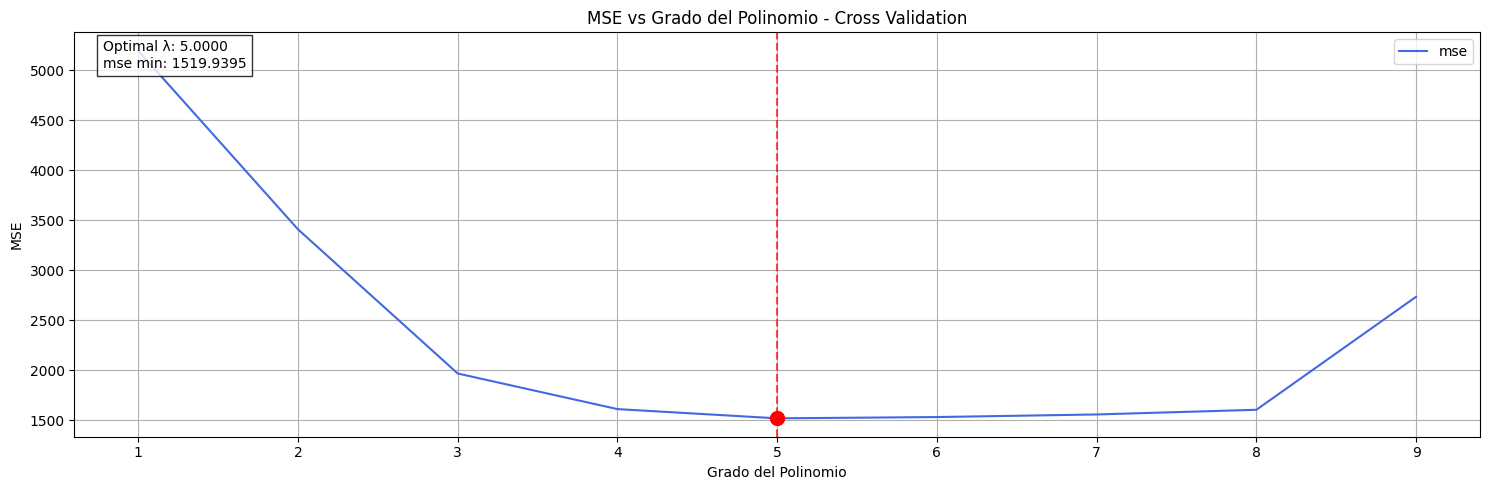

El mejor grado es: 5
MSE mínimo (CV): 1519.9395


In [40]:
from utils.visuals import plot_metric_vs_lambda


fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

min_degree, min_mse = plot_metric_vs_lambda(ax1, degrees, cv_error_scores['mse'], metric_name='mse')

ax1.set_xlabel('Grado del Polinomio')
ax1.set_ylabel('MSE')
ax1.set_title('MSE vs Grado del Polinomio - Cross Validation')

plt.tight_layout()
plt.show()

print(f"El mejor grado es: {min_degree}")
print(f"MSE mínimo (CV): {min_mse:.4f}")

#### Entrenamos el modelo con el grado optimo

In [41]:
 
results_polynomial_optimal_degree = train_and_evaluate_model(
    data_path=df_eng_dev_path,
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=PolynomialRegressor.change_degree(OPTIMAL_DEGREE),
    transform_target=np.log,
    normalize_features=True,
    inv_transform_pred=np.exp,
    fit_params={'method': 'pseudo_inverse'},
    metrics=[mse_score, r2_score],
    verbose=False
)

mse_polynomial_optimal_degree = results_polynomial_optimal_degree["mse"]
r2_polynomial_optimal_degree = results_polynomial_optimal_degree["r2"]

print(f"MSE del modelo polinómico: {mse_polynomial_optimal_degree:.4f}")
print(f"R2 del modelo polinómico: {r2_polynomial_optimal_degree:.4f}")

model_polynomial_optimal_degree = results_polynomial_optimal_degree["model"]

normalization_params_optimal_degree = results_polynomial_optimal_degree['normalization_params']


MSE del modelo polinómico: 569.8850
R2 del modelo polinómico: 0.9953


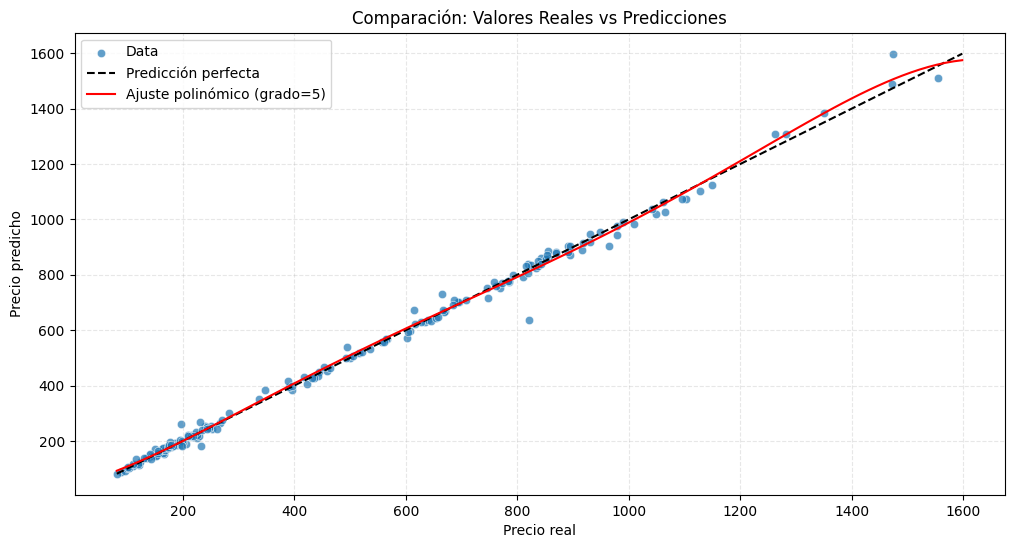

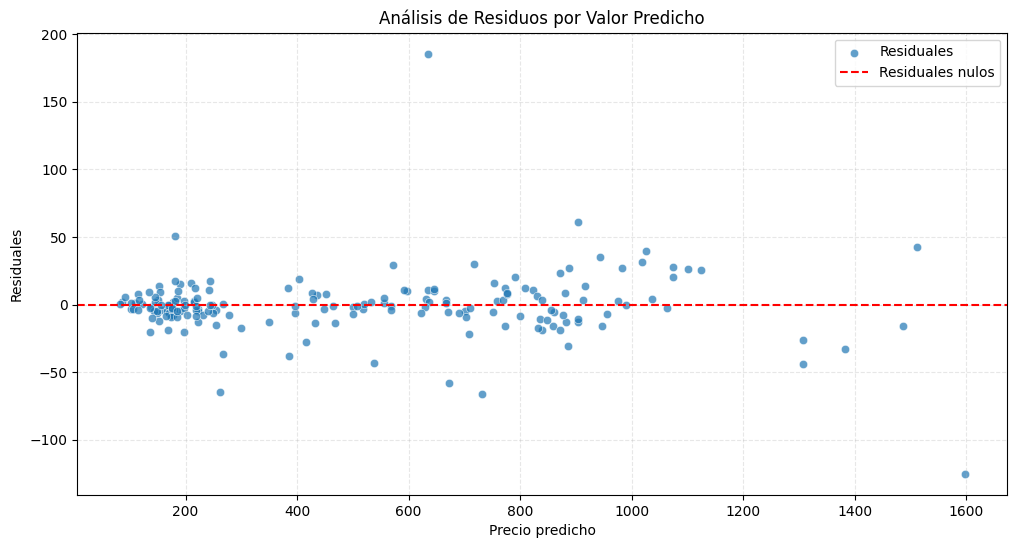

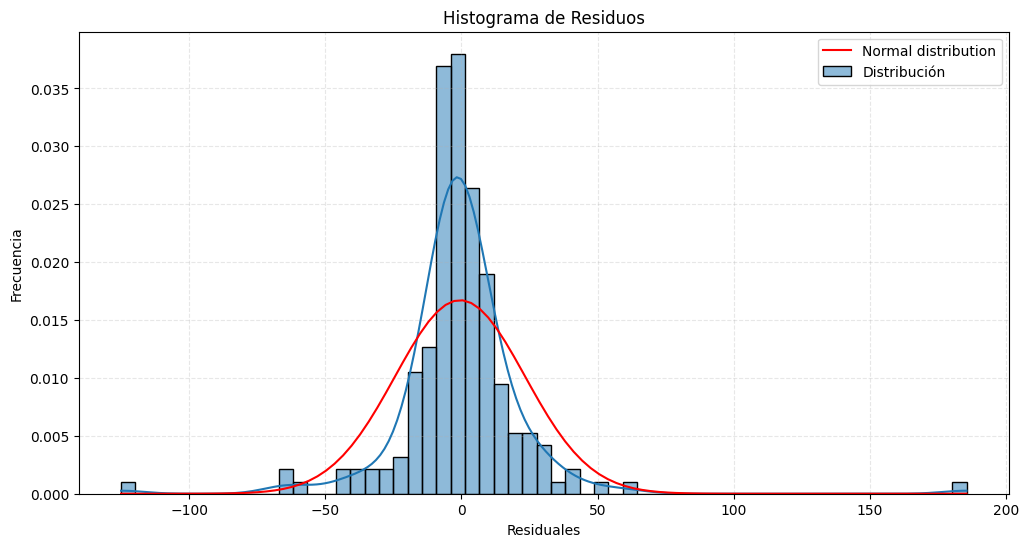

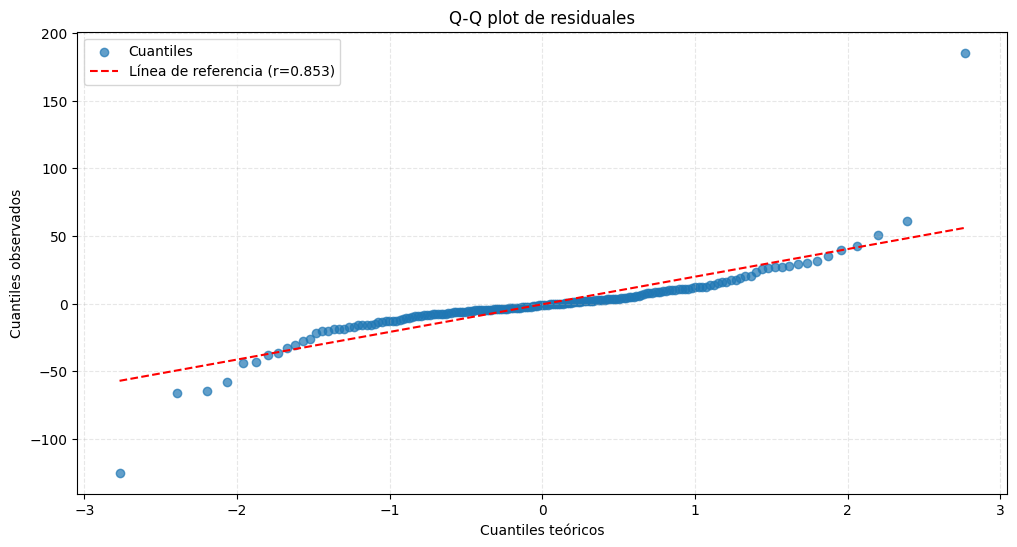

In [42]:
figures_engineering = visualize_regression_results(
    results_polynomial_optimal_degree['y_test'],
    results_polynomial_optimal_degree['y_pred_test'],
    transform_func=np.exp,
    fig_size=(12, 6),
    titles=custom_titles,
    show_figures=True,
    fit_degree=OPTIMAL_DEGREE
)

Observamos que el modelo polinómico presenta un mejor ajuste que el lineal que se analizó previamente. En el Q-Q plot se observan desviaciones en ambos extremos de la línea de referencia, lo que indica que los residuos no se distribuyen exactamente de forma normal; sin embargo, esta característica es acompañada por una mayor concentración de residuos cerca de cero. Esto sugiere que, a pesar de la presencia de algunas colas alargadas (probablemente por outliers), el modelo polinómico captura mejor la variabilidad de los datos sin incurrir en un sobreajuste, ya que un modelo overfitted mostraría residuos excesivamente concentrados en cero.

Complementariamente, el gráfico de la distribución de residuos muestra que, si bien ambos modelos presentan una forma cercana a la normal, el polinómico exhibe una “cola” más larga pero con mayor densidad de residuos en torno a cero en comparación con el lineal. Esto indica que, en términos generales, el modelo polinómico predice con mayor precisión, ya que produce menos errores de gran magnitud y mantiene una variación de residuos más uniforme a lo largo del rango de valores predichos.

Al incorporar un polinomio de grado 5, se mitiga en gran medida la heterocedasticidad, lo que refuerza la idea de que el modelo polinómico tiene un desempeño superior al lineal.

### Punto 4.3

In [43]:

df_300 = pd.read_csv(df_preprocessed_path)
print(df_300.isna().sum())
df_numeric = df_300.select_dtypes(include=['float64', 'int64']).columns

feature_ops_300 = []
features_count = 0
powers = range(1, 40)  

for col in df_numeric:
    for power in powers:
        if features_count >= 300:
            break
            
        feature_ops_300.append({
            'name': f'{col}_power_{power}',
            'operation': lambda df, col=col, power=power: df[col] ** power
        })
        features_count += 1
        
    if features_count >= 300:
        break

results = process_dataset(
    df=df_300,
    kmeans_model=kmeans, # mismo modelo usado para agrupar las zonas
    feature_engineering_ops=feature_ops_300,
    location_columns=None,
    features_to_impute=['age', 'rooms']
    )

processed_300_df = results['df']




area        0
is_house    0
has_pool    0
age         0
price       0
lat         0
lon         0
rooms       0
dtype: int64


In [44]:

results_300 = train_and_evaluate_model(
    df=processed_300_df, 
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=LinearRegressor,
    transform_target=None,
    normalize_features=False,
    fit_params={'method': 'pseudo_inverse'},
    metrics=[mse_score, r2_score],
    verbose=False
)

mse_300 = results_300["mse"]
r2_300 = results_300["r2"]

print(f"Mean Squared Error: {mse_300:.2f}")
print(f"R2 Score: {r2_300:.2f}")


Mean Squared Error: 366588.81
R2 Score: -2.00


Se esperaba que la incorporación masiva de 300 features, generadas como potencias de las variables numéricas originales, empeorara drásticamente el desempeño del modelo. En lugar de aportar información útil, estas transformaciones generan variables altamente correlacionadas y redundantes, lo que conduce a sobreajuste, inestabilidad numérica y problemas de interpretación, haciendo que el modelo ande mal. Los resultados (con un MSE de 366588.81, un R² de -2.00) confirman que esta estrategia no tiene sentido, ya que agranda la dimensión del problema sin aportar mejoras predictivas, sino que, por el contrario, deteriora significativamente la calidad del modelo.

# Punto 5


#### Punto 5.1

$\text{En el archivo \texttt{src/models/regression/polynomial\_regressor.py}, clase padre de \texttt{LinearRegressor},}$ 
$\text{se encuentra la implementación de la regularización Ridge y Lasso.}$

#### Punto 5.2

In [45]:

from utils.model import get_weights_and_metrics
from utils.visuals import plot_weights_vs_lambda

df = pd.read_csv(df_eng_dev_path)

X = df.drop('price', axis=1)
y = df['price']


lambdas_0_10 = np.linspace(0, 10, 200)
feature_names = X.columns


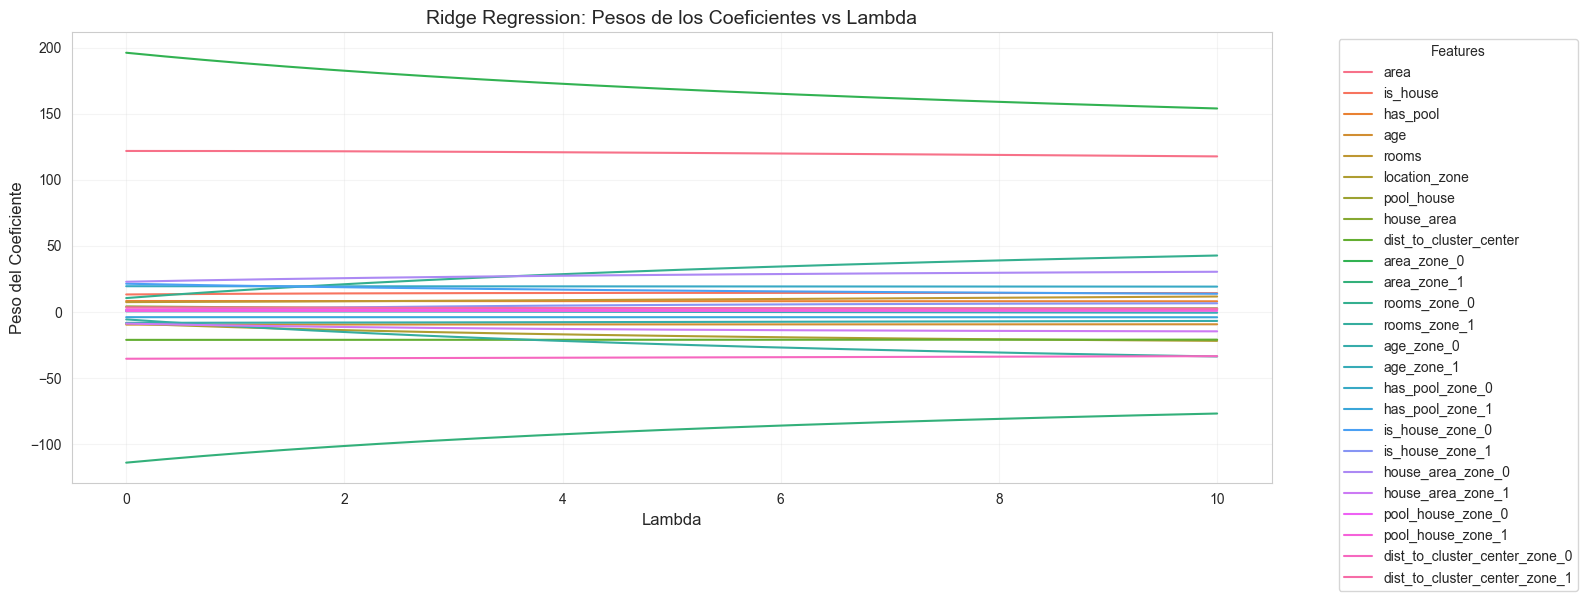

In [46]:

weights_ridge_0_10, mse_scores_ridge_0_10, r2_scores_ridge_0_10 = get_weights_and_metrics(X, y, lambdas_0_10, LinearRegressor, normalize=True, method='pseudo_inverse', regularization='l2',random_state=12)

plot_weights_vs_lambda(lambdas_0_10, weights_ridge_0_10, feature_names,custom_titles={"title": "Ridge Regression: Pesos de los Coeficientes vs Lambda", "xlabel": "Lambda", "ylabel": "Peso del Coeficiente"})



#### Punto 5.3

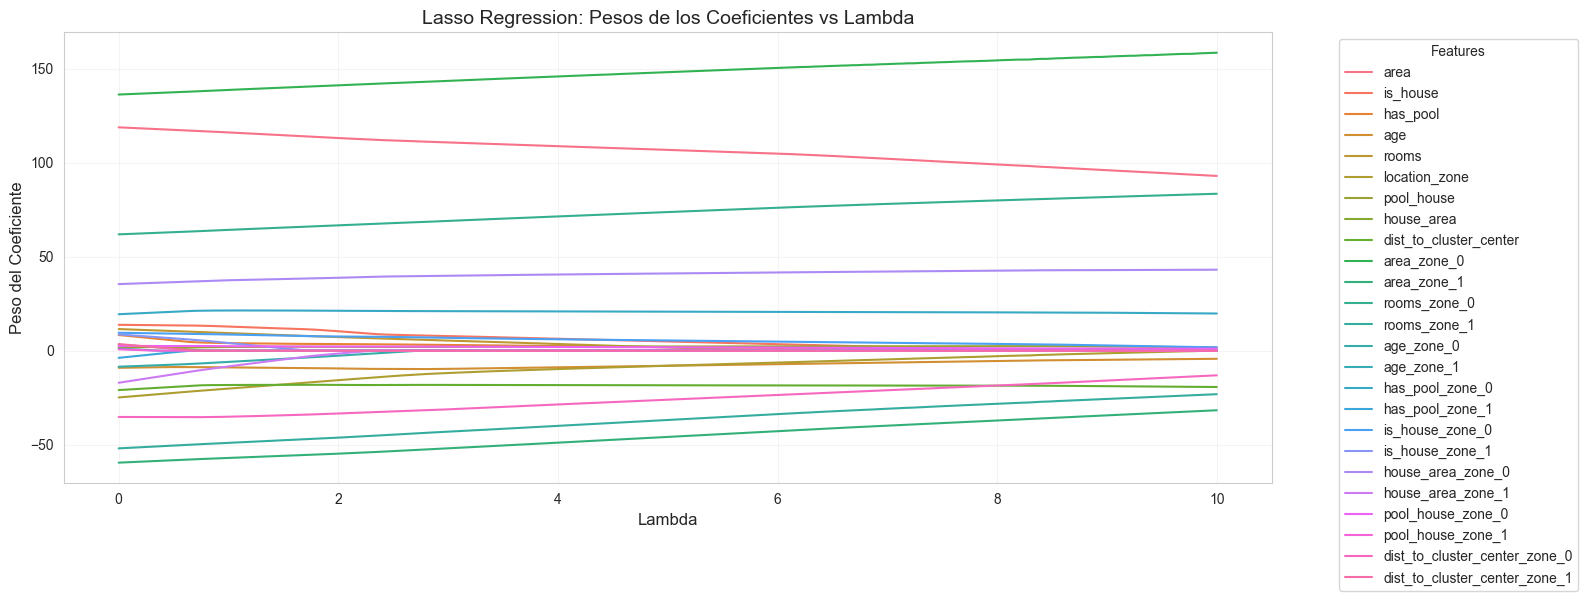

In [47]:
weights_lasso_0_10, mse_scores_lasso_0_10, r2_scores_lasso_0_10 = get_weights_and_metrics(X, y, lambdas_0_10, LinearRegressor, normalize=True, method='gradient_descent', regularization='l1',random_state=12)
plot_weights_vs_lambda(lambdas_0_10, weights_lasso_0_10, feature_names,custom_titles={"title": "Lasso Regression: Pesos de los Coeficientes vs Lambda", "xlabel": "Lambda", "ylabel": "Peso del Coeficiente"})


El uso de regularización L1 (Lasso) y L2 (Ridge) tiene efectos distintos en los coeficientes del modelo: Lasso tiende a llevar varios coeficientes exactamente a cero, lo que implica una selección de variables automática y favorece la interpretabilidad del modelo, mientras que Ridge reduce gradualmente la magnitud de todos los coeficientes sin anularlos, distribuyendo el peso entre las variables y haciendo el modelo más estable cuando hay colinealidad. Así, Lasso es útil cuando se busca un modelo más simple y con menos variables relevantes, mientras que Ridge es preferible cuando todas las variables contienen información importante y se quiere evitar sobreajuste sin eliminar ninguna.

#### Punto 5.4

Al inspeccionar los gráficos, se observa que, conforme aumenta λ, los coeficientes tienden a reducirse en magnitud y estabilizarse, lo que indica mayor regularización. Un λ demasiado pequeño podría dejar al modelo sobreajustado (coeficientes muy grandes), mientras que uno muy grande podría anular en exceso (Lasso) o comprimir demasiado (Ridge) los coeficientes importantes. Aproximadamente en el rango de λ≈3–5 se aprecia que los coeficientes con mayor relevancia todavía conservan valores notables, sin mostrar la variabilidad extrema de λ muy bajos ni la excesiva reducción de λ muy altos. Sin embargo, la mejor forma de afinar esta elección es mediante validación cruzada, seleccionando el λ que minimice el error de validación y equilibre adecuadamente la magnitud de los coeficientes con la capacidad predictiva del modelo. Se prueba a continuación λ = 5.

In [48]:
results_ridge_lambda_5 = train_and_evaluate_model(
    data_path=df_eng_dev_path,
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=LinearRegressor,
    transform_target=np.log,
    normalize_features=True,
    inv_transform_pred=np.exp,
    fit_params={'method': 'pseudo_inverse',
                'regularization': 'l2',
                'alpha': 5},
    metrics=[mse_score, r2_score],
    verbose=False)

mse_ridge_lambda_5 = results_ridge_lambda_5["mse"]
r2_ridge_lambda_5 = results_ridge_lambda_5["r2"]

print(f"MSE del modelo Ridge con lambda = 5: {mse_ridge_lambda_5:}")
print(f"R2 del modelo Ridge con lambda = 5: {r2_ridge_lambda_5:}")

MSE del modelo Ridge con lambda = 5: 5684.641701047873
R2 del modelo Ridge con lambda = 5: 0.9534246216849707


La regularización L2 beneficia significativamente a los modelos lineales al añadir un término de penalización basado en la suma de los cuadrados de los coeficientes. Este mecanismo produce varios efectos positivos en la predicción de precios de viviendas. Primordialmente, combate el sobreajuste al desincentivar que el modelo asigne pesos excesivamente grandes a características específicas, logrando así un mejor equilibrio entre sesgo y varianza. Cuando existen variables altamente correlacionadas (multicolinealidad), como suele ocurrir en datos inmobiliarios donde área, número de habitaciones y otros atributos pueden estar relacionados, la regularización L2 estabiliza la solución numérica distribuyendo la importancia entre todas las variables relacionadas en lugar de asignar coeficientes extremos a alguna de ellas. A diferencia de otras técnicas como Lasso, Ridge mantiene todas las variables en el modelo pero reduce su impacto proporcionalmente, lo que resulta particularmente útil cuando se cree que todas las características contribuyen en alguna medida al precio. El hiperparámetro alpha (en este caso 5) controla la intensidad de la regularización, permitiendo ajustar el modelo según la complejidad de los datos y evitando que se vuelva demasiado sensible a particularidades de los datos de entrenamiento, lo que mejora su capacidad predictiva en datos nuevos.


#### Punto 5.5

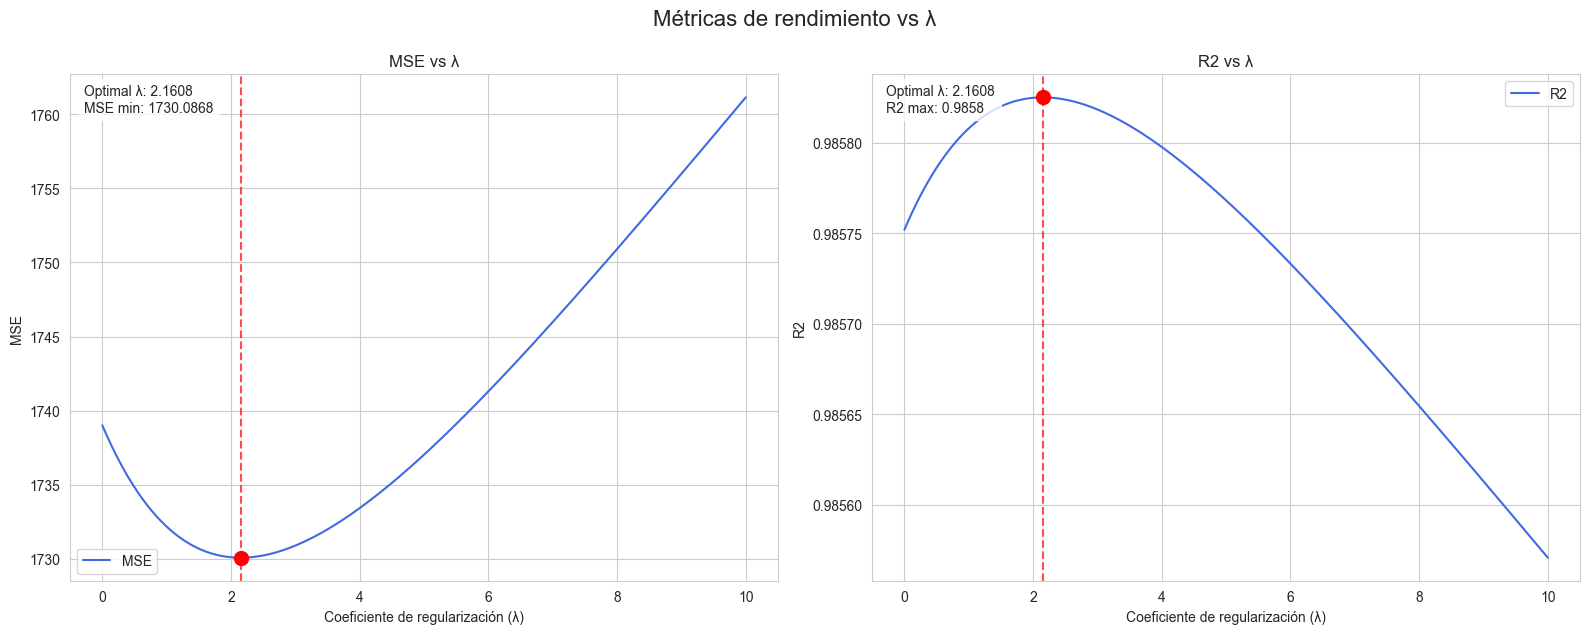

Min lambda para r2 y mse:  2.1608040201005028
Max lambda para r2 y mse:  2.1608040201005028


In [49]:
from utils.visuals import plot_performance_metrics

# el mínimo/máximo es el mismo lambda para r2 y mse ya que r2 es una función del mse (elevado a -1)
min_lambda_ridge, min_mse_ridge, max_lambda_ridge, max_r2_ridge = plot_performance_metrics(lambdas_0_10, mse_scores_ridge_0_10, r2_scores_ridge_0_10,random_state=12)

print("Min lambda para r2 y mse: ", min_lambda_ridge)
print("Max lambda para r2 y mse: ", max_lambda_ridge)


In [50]:

print(f"MSE del modelo Ridge con lambda = 5: {min_mse_ridge:}")
print(f"R2 del modelo Ridge con lambda = 5: {max_r2_ridge:}")

MSE del modelo Ridge con lambda = 5: 1730.086763756706
R2 del modelo Ridge con lambda = 5: 0.9858250616701243


Se observa una mejora espléndida en el R2 y MSE, pasando de tener un MSE de 5684 a 1730, y un R2 de 0.95 a 0.98.

## Punto 5.6

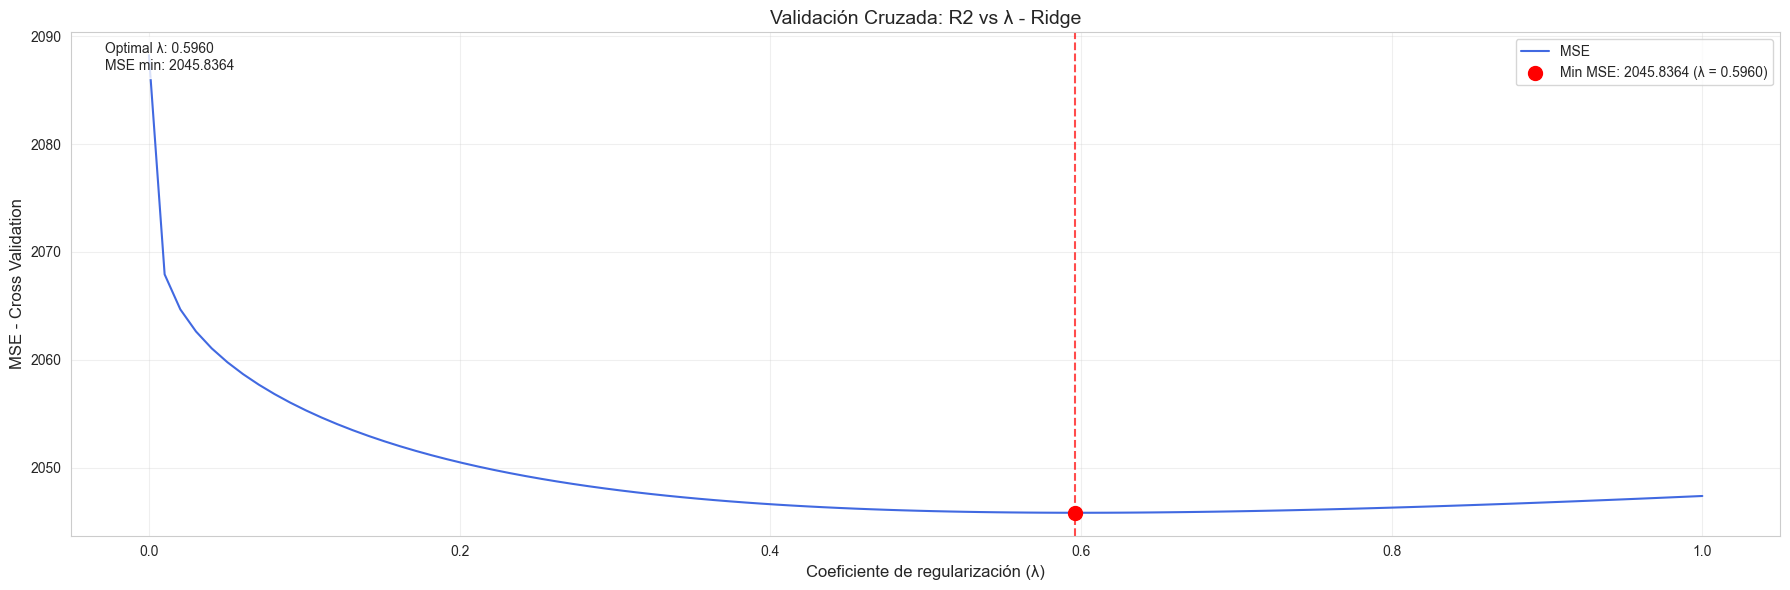

Mejor λ según MSE: 0.595960, MSE mínimo: 2045.836405


In [51]:
from utils.visuals import plot_cv_results

df = pd.read_csv(df_eng_dev_path)
y = df['price']
X = df.drop(columns=['price'])

lambdas = np.linspace(0, 1, 100)

optimal_lambda_ridge, min_cv_error_ridge, cv_error_scores_ridge = cross_validate_lambda(
    X, y, lambdas, PolynomialRegressor.change_degree(OPTIMAL_DEGREE), n_splits=10, method='pseudo_inverse', 
    regularization='l2', normalize=True, random_state=12,
    metrics=[mse_score],
    variable='penalty'
)

fig, ax1 = plt.subplots(1, 1, figsize=(18, 6))


ax1 = plot_cv_results(
    lambdas, 
    cv_error_scores_ridge['mse'], 
    optimal_lambda_ridge['mse'], 
    min_cv_error_ridge['mse'], 
    title="Validación Cruzada: R2 vs λ - Ridge",
    ax=ax1
)


plt.tight_layout()
plt.show()

OPTIMAL_LAMBDA_RIDGE_POLY = optimal_lambda_ridge['mse']

print(f"Mejor λ según MSE: {OPTIMAL_LAMBDA_RIDGE_POLY:.6f}, MSE mínimo: {min_cv_error_ridge['mse']:.6f}")


Se observa una diferencia en el mejor lambda para la regularización Ridge. Cuando se realizó el barrido sin cross validation, el mejor lambda era 2.16, pero al agregar cross validation, el mejor lambda es 0.59.

Esto se debe a que, al utilizar cross validation, se hace un promedio del desempeño del modelo en los folds para cada lambda, y se selecciona la lambda óptima para el modelo. Esto es un approach más robusto que el barrido sin cross validation, ya que se tiene en cuenta el desempeño del modelo en diferentes configuraciones de entrenamiento, y no solo en un split específico. Es por esto que, en caso de utilizar un modelo de regresión lineal, se utilizaría el lambda óptimo encontrado por cross validation para el modelo.

#### Puntito extra... Mejorando el modelo polinómico

In [52]:
results_polynomial_optimal_degree_reg = train_and_evaluate_model(
    data_path=df_eng_dev_path,
    target_column="price",
    test_size=0.20,
    random_state=12,
    model_class=PolynomialRegressor.change_degree(OPTIMAL_DEGREE),
    transform_target=np.log,
    normalize_features=True,
    inv_transform_pred=np.exp,
    fit_params={'method': 'pseudo_inverse',
                'regularization': 'l2',
                'alpha': OPTIMAL_LAMBDA_RIDGE_POLY},
    metrics=[mse_score, r2_score],
    verbose=False)

model_polynomial_optimal_degree_reg = results_polynomial_optimal_degree_reg["model"]

normalization_params_optimal_degree_reg = results_polynomial_optimal_degree_reg['normalization_params']

mse_polynomial_optimal_degree_reg = results_polynomial_optimal_degree_reg["mse"]
r2_polynomial_optimal_degree_reg = results_polynomial_optimal_degree_reg["r2"]

print(f"MSE del modelo polinómico regularizado (Ridge): {mse_polynomial_optimal_degree_reg:.4f}")
print(f"R2 del modelo polinómico regularizado (Ridge): {r2_polynomial_optimal_degree_reg:.4f}")



MSE del modelo polinómico regularizado (Ridge): 491.8340
R2 del modelo polinómico regularizado (Ridge): 0.9960


$\text{0.99 de R2 en el set de validación}!!$ (*￣､ゝ￣) 

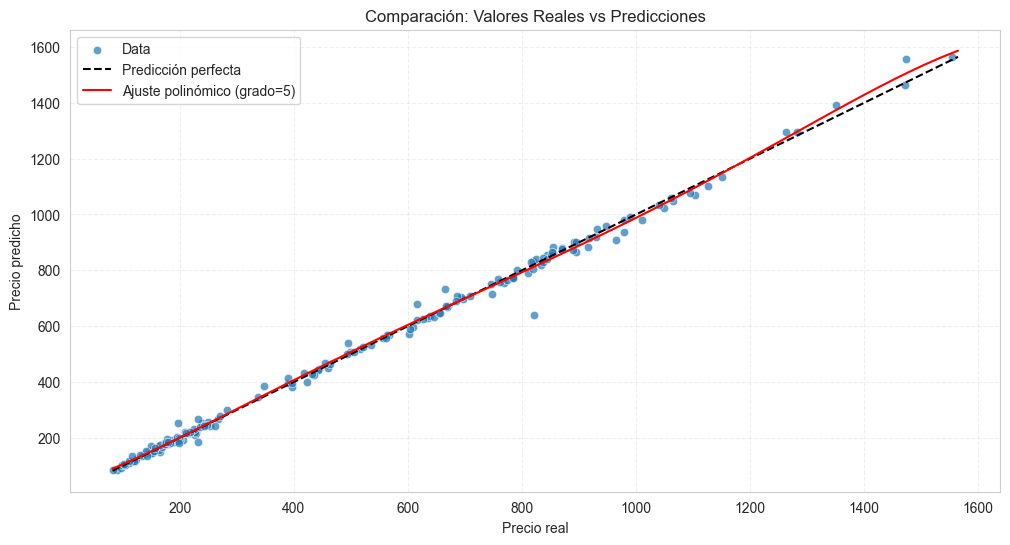

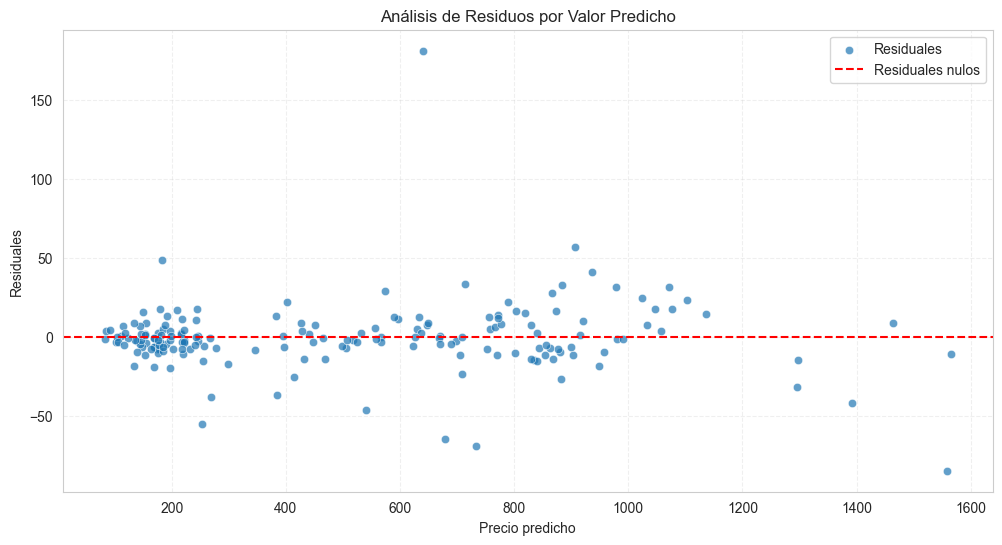

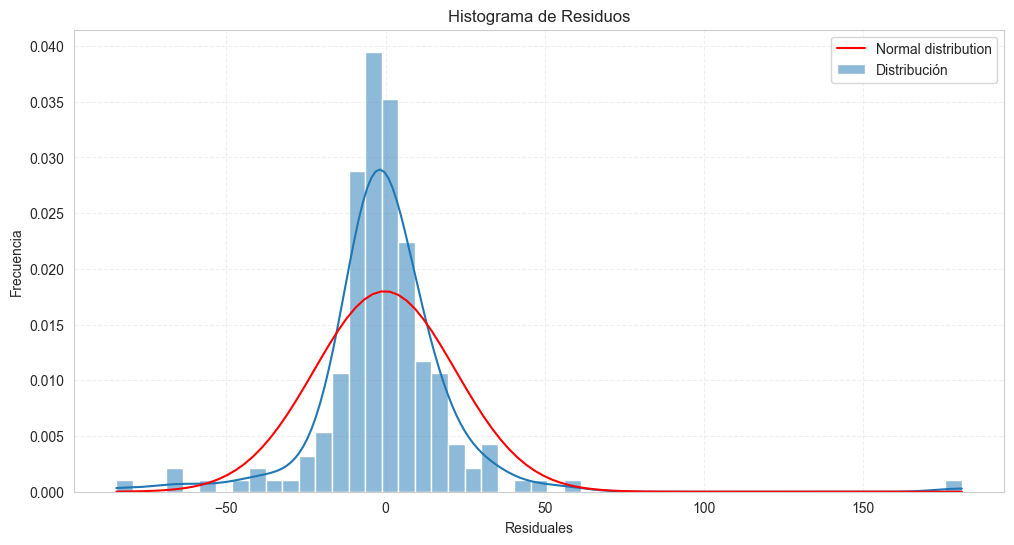

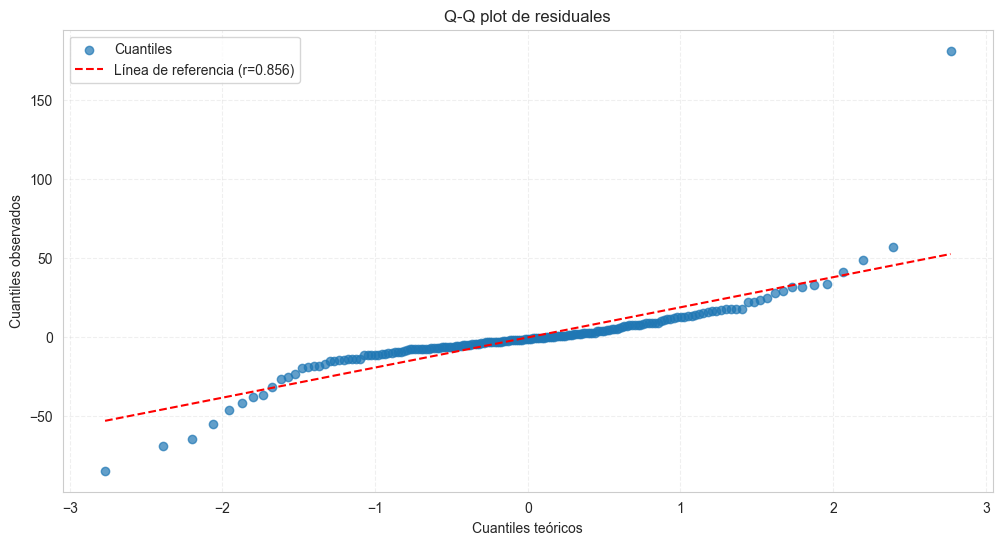

In [53]:
figures_engineering = visualize_regression_results(
    results_polynomial_optimal_degree_reg['y_test'],
    results_polynomial_optimal_degree_reg['y_pred_test'],
    transform_func=np.exp,
    fig_size=(12, 6),
    titles=custom_titles,
    show_figures=True,
    fit_degree=OPTIMAL_DEGREE
)

La felicidad, algunos argumentan, es el objetivo supremo de la vida y la realización plena de la naturaleza humana, y que se alcanza a través de la virtud y el equilibrio entre el cuerpo, el alma y los bienes externos.

Sin embargo, es de carácter menester refutar esta definición, ya que la felicidad es, en pocas palabras, ver como un modelo de machine learning obtiene un R2 de 0.99 en el set de validación (aún así, un análisis utilizando cross validation sería más robusto). Al observar la distribución de residuos, se observa un $'' \text{pico} ''$ alrededor del cero, lo que indica que ```y_pred``` se asimila en gran medida a ```y_test```(indicando que las predicciones se acercan bastante a los valores reales), lo cual sugiere que el modelo no está $`` \text{aprendiendo} ''$ ruido específico de los datos de entrenamiento. Asimismo, en el gráfico de residuos vs. valores predichos no se aprecian patrones sistemáticos ni tendencia (por ejemplo, una forma de “U” o “S”), sino que los puntos se dispersan de manera aleatoria alrededor de la línea de cero. Esto indica que los errores son esencialmente aleatorios, y no hay evidencia de que el modelo esté capturando peculiaridades o fluctuaciones irrelevantes de los datos. Finalmente, la comparación entre valores reales y predicciones muestra una alineación muy cercana con la línea de ajuste ideal sin picos o $`` \text{oscilaciones} ''$ marcadas, y el hecho de que el R^2 alto (0.99) se mantenga en el conjunto de validación confirma que el desempeño se conserva en datos no vistos.

# Punto 6 - PRUEBA DE FUEGO 

In [54]:
df_test = pd.read_csv(df_preprocessed_test_path)


print(list(get_nan_features(df_test)))

['age', 'rooms']


In [55]:

df_eng_test_path = "../data/processed/casas_test_eng_mean_impute.csv"

processed = process_dataset(
    df=df_test,
    kmeans_model=kmeans,  # es el mismo modelo que en el entrenamiento
    feature_engineering_ops=engineering_ops,
    features_to_impute=['rooms', 'age'],
    location_columns=['lat', 'lon'],
    impute_by_zone=True, 
    create_zone_interactions=True,
    zone_interaction_features=['area', 'rooms', 'age', 'has_pool', 'is_house', 'house_area', 'pool_house', 'dist_to_cluster_center'],
    save_path=df_eng_test_path
)

df_test_processed = processed['df']

df_test_processed.head()



,area,is_house,has_pool,age,price,rooms,location_zone,pool_house,house_area,dist_to_cluster_center,...,has_pool_zone_0,has_pool_zone_1,is_house_zone_0,is_house_zone_1,house_area_zone_0,house_area_zone_1,pool_house_zone_0,pool_house_zone_1,dist_to_cluster_center_zone_0,dist_to_cluster_center_zone_1
0,65.000000,0,1,8.0,120.0,2.0,1,0,0.0,0.024511,...,0,1,0,0,0.0,0.0,0,0,0.000000,0.024511
1,66.000000,1,1,8.0,143.0,2.0,1,1,66.0,0.052256,...,0,1,0,1,0.0,66.0,0,1,0.000000,0.052256
2,129.042267,0,0,6.0,971.0,4.0,0,0,0.0,0.040525,...,0,0,0,0,0.0,0.0,0,0,0.040525,0.000000
3,96.000000,1,0,19.0,168.0,3.0,1,0,96.0,0.085689,...,0,0,0,1,0.0,96.0,0,0,0.000000,0.085689
4,99.000000,1,0,9.0,183.0,3.0,1,0,99.0,0.066246,...,0,0,0,1,0.0,99.0,0,0,0.000000,0.066246


In [56]:
from utils.model import prepare_and_evaluate_test_data

metrics, X_test, y_test, y_test_log = prepare_and_evaluate_test_data(
    df_test=df_test_processed,
    model=model_polynomial_optimal_degree,
    normalization_params=normalization_params_optimal_degree,
    transform_target_func=np.log,
    inv_transform_pred=np.exp,
    print_metrics=True
)


MSE: 3028.9614
R2: 0.9678


In [57]:

metrics, X_test, y_test, y_test_log = prepare_and_evaluate_test_data(
    df_test=df_test_processed,
    model=model_polynomial_optimal_degree_reg,
    normalization_params=normalization_params_optimal_degree_reg,
    transform_target_func=np.log,
    inv_transform_pred=np.exp,
    print_metrics=True
)


MSE: 2978.4753
R2: 0.9683


Se toman los dos modelos de mejor desempeño, y se comparan los resultados. En este caso, se elige el modelo polinómico de grado 5 con regulación Ridge, pues es el que mejor se desempeña en el conjunto de datos de entrenamiento. Este modelo sería el que se utilizaría para hacer predicciones sobre nuevos datos. A la hora de poner en producción, se debería asegurar de que antes de predecir, se normalice el nuevo conjunto de datos con los parámetros del entrenamiento, y aplicar la transformación logarítmica al target.
Luego, se debería aplicar la transformación inversa al target para obtener el precio real.